<a href="https://colab.research.google.com/github/Vikadie/AI-repo/blob/master/NER_and_Entity_Linking_in_legal_documents_in_Bulgarian_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import os
import re
from time import time
import json
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import seed

In [3]:
!pip install -q -U tf-models-official
!pip install -q -U tensorflow-text

In [3]:
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_text as text  # A dependency of the preprocessing model

from official.nlp import bert
from official.nlp.bert.tokenization import FullTokenizer

tf.get_logger().setLevel('ERROR')

ModuleNotFoundError: ignored

In [4]:
tf.__version__

'2.4.1'

In [5]:
# GPU availability test
gpus = tf.config.list_physical_devices('GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
tf.debugging.set_log_device_placement(True)  
# should display on which device the operations are assigned to

[]
0 Physical GPUs, 0 Logical GPU


In [7]:
# # making it the old way - with tf1 and source from original repo
# import sys

# !test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
# if not 'bert_repo' in sys.path:
#   sys.path += ['bert_repo']

# # import python modules defined by BERT
# import modeling

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

from official.nlp import optimization

from official.nlp.optimization import AdamWeightDecay, WarmUp
from tensorflow_addons.metrics import F1Score
from tensorflow_addons.optimizers import AdamW

from seqeval.metrics import f1_score, classification_report, precision_score, recall_score 

# NER and Entity Linking in unstructured legal documents in Bulgarian language

##### Final exam report

*Viktor Belchev - student*

*Deep Learning - Software University*

*February 2021*

## Abstract

Abstract

In all legal documents there is usage of citation of different laws or other juridical terms often hidden behind some abbreviations. While this aims to make the text shorter and clearer it is mostly causing troubles in understanding and translation to simple language not only to regular persons, but sometimes even lawyers and people with juridical background feel lost. Therefore, it often requires an additional research in the legal litterature. At this stage another problem might occur - the correct decoding of abbreviated terms can become obstacle on top of the the overall understanding of the information.

In this paper, I will try to use the modern approach of Deep Learning to create a helpful tool that overcomes these problems. Using the state-of-the-art available models in the field of Natual Language Processing like BERT and an abbreviation list available at this stage, I will try to achieve an acceptable accuracy in this task for Bulgarian language that is known as combination of two different tasks: Named Entity Recognition and Entity Linking. 

## Introduction

Generally, in Natural Language Processing (further, NLP) the process of disambiguation of terms is known as Entity Linknig (further, EL), which goes hand in hand with another operation called Named Entity Recognition (further, NER). As explained by Iva Marinova in her **"Reconstructing NER Corpora: a Case Study on Bulgarian"** while in the field of Deep Learning 
these two related tasks are considered to be well covered in
NLP for Germanic, Romance and other language groups,
they are still under-resourced for the Slavic languages, especially from a multilingual perspective.

Usually, the order of application of both tasks is by starting with NER.

The purpose of NER is to tag words in a sentences based on some predefined tags, in order to extract some important information of the sentence, like for instanse names, geographical locations, dates, currency etc.
In NER, each token in the sentence will get tagged with a label, the label will tell the specific meaning of the token. In that way, through NER, we can analyze the sentence with more details and extract the important information.

There are two popular approaches for NER:
- multi-class classification based where NER is treated as a multi-class classification process, and we can use some text classification method to label the token.
- Conditional Random Field(CRF) based method labels the token taking context into account, then predicts sequences of labels for sequences of sentence token then get the most reasonable one. It is a probabilistic graphical model.

The identification of named entity mentions in texts is often implemented using a sequence tagger, where each token is labeled with an BIO tag, indicating whether the token begins a named entity — (B-), whether it is inside of a named entity (I-), or outside of a named entity (O-). This type of annotation has been proposed for the first time at CoNLL-2003 dataset created for NER (Tjong Kim Sang and De Meulder, 2003). There are other tag notation types. For instance, each token can be predicted with a tag indicated by B-(begin), I-(inside), E-(end), S-(singleton) of a named entity with its type, or O-(outside) of named entities. But, I will stick to BIO format of representation for simplicity.

Entity linking can be applied rigth after the NER task is performed althought in some papers on this topic there is proposal to do it in parallel (jointly) for each token, so that each subtask benefits from the partial output of the other subtask, and thus alleviate error propagations that are unavoidable in pipeline settings. 
Generally, EL is the task of mapping words from text (e.g. names of persons, locations and organizations) to entities from the target knowledge base. For this pupose I use a document containing most of the existing abbreviations used in legal documents.

## NER

Usually, no matter the specific task, Deep Learning models creation is based on big data for training, validation and test. For Bulgarian language generally such data could be available if we start scraping web pages, which is huge amount of work. But this is only one side of the hidden obstacles - the effectiveness of the model created for the task is a real challenge on its own. 

Luckily, after the publication of the famous paper called "Attention is all you need" by Vaswani and the "appearance" of *Transformer*, there is a huge advancement in the model creation compared to previous usage of recurrence (RNN), Bidirectional Lont-Short Term Memory units (BiLSTM), convolutions (CNN) and CRF. Transformer utilizes stacked self-attention and pointwise, fully connected layers to build basic blocks for encoder and decoder.  Experiments on various tasks show Transformers to be superior in quality while requiring significantly less time to train.

Based mostly on transformer, it already exists pre-trained models that provide results pretty close to humans on some general tasks. Some of the most used methods are ELMo(Embeddings from Language Models), OpenAI GPT (Generative Pre-trained Transformer), BERT (Bidirectional Encoder Representations from Transformers)... 

It is important to underline that these state-of-the-art models use specific representation of the text, called embeddings, usually so called *hybrid representation* of text in low dimensional real-valued dense vectors. It is called *hybrid* as it uses *Word-level* and *Character-level* representation along with some additional features, where each dimensions represents a latent feature. This way it also captures the semantic and syntactic properties of words, but also the context for each word.

In recent years, the advancements of NLP in general and NER in particular has been greatly influenced by deep transfer learning methods capable of creating contextual representations of words, to the extent that many of the state-of-the-art NER systems mainly differ from one another on the basis of how these contextual representations are created. Using such models, sequence tagging tasks are often approached one sentence at a time, essentially discarding any information available in the broader surrounding context, and there is only little recent study on the use of cross-sentence context – sentences around the sentence of interest – to improve sequence tagging performance.

Precisely for the fact of using this cross-sentence context, but also with the advantage to be pre-trained on Bulgarian texts, in this notebook, I focus on the recent BERT deep transfer learning models based on self-attention and the transformer architecture. BERT uses a fixed-size window that limits the amount of text that can be input to the model at one time. The model maximum window size, or maximum sequence length, is fixed during pre-training, with 512 wordpieces a common choice. This window fits dozens of typical sentences of input at a time, allowing the inclusion of extensive sentence context.

There are many advantages that pushed me towards usage of BERT. To enumerate some, I would say that it provides:
1. quicker development
2. overcome the problem of missing data for training, which is generally the case for Bulgarian
3. state-of-the-art better results - BERT is built on top of a number of clever ideas considered top in NLP community in latest years – including but not limited to Semi-supervised Sequence Learning (by Andrew Dai and Quoc Le), ELMo (by Matthew Peters and researchers from AI2 and UW CSE), ULMFiT (by fast.ai founder Jeremy Howard and Sebastian Ruder), the OpenAI transformer (by OpenAI researchers Radford, Narasimhan, Salimans, and Sutskever), and the Transformer (Vaswani et al).

BERT is also one of the preferred model giving the best results used by Ilias Chalkidis et al. when dealing with  Large-Scale Multi-Label Text Classification (LMTC) in the legal domain (EU legislation).

On the other hand, there are some disadvantages, like:
1. it is very large. The LARGE version of BERT would provide better results, but unfortunately that would require bigger computational ability and time.
2. Even when using the BASE version, it remains slow for fine-tuning.
3. The multilingual version that I need to use cannot be disitilled - the vocabulary used for fine-tuning of BERT must remain the original one.
4. It uses a specific and a bit complicated jargon (domain-specific language), meaning that the tokenization with BERT should be done with BERT Tokenizer.

The last two disadvantages represent in fact the specifity and maybe the strength of BERT. Its vocabulary is indeed fixed, but it has the capability to break down the unknown word into subwords and makes a token out of each subword (if subword exists in the vocabulary). In case the subword do not exist in the vocabulary it can continue spliting it into subwords down to a character level. To recognize the subword it prepends it with "##" flag, except for the first subword.

On its turn the subword split would create a problem with labeling. Generally, in the test and train part each word is tagged. If an unknown word is splitted to subwords, a specific tag should be used for it, that would indicate that the tag valid for this word (the initial whole word) would be the one given to the first subword (original word) and a specific tag would be assigned to subwords after the first one.

### Dataset creation

Before getting to the problem of tags given to subwords, we need a dataset, big enough, that can be used to fine-tune our BERT model. This dataset should implement the following requirements:
   - it must be created for a NER task;
   - it must be in Bulgarian;
   - it must contain special annotations (tags) for recognition of legal phrases;
   - it must be big enough to train deep network model;
   - ideally it should have a train, validation and test datasets.

Well, the first four requirements need to be mandatory fulfilled. After all if the dataset is big enough there are ways and methods to make a consise split for train, validation and test datasets. 

But it is hard task to implement all four requirements. In fact, I was not able to find such dataset on Internet. Luckily, there is one dataset recently created for NER task, which was in Bulgarian - the dataset done by Iva Marinova et al. pesented in May 2020. The dataset is available at https://github.com/usmiva/bg-ner. With it, I could cover half of the requirements for my task. Unfortunately, as it was not created for utilization on legal texts, there were not a specific tag for legal phrases inside. Still, it was the best one I could find. Therefore, I decided to use it as a base, a starting point, and add to it the required information covering the legal part gathered by me.

But before start adding information, let me reveal what and how is implemented inside, in order to decide at what level it will suit me and how to add the missing information.

The original Bulgarian corpus consists of 916 text files extracted from various news websites. The training dataset contains information on two topics – Brexit and the trial of the Pakistani Christian Asia Bibi, accused of blasphemy, while the main subjects for the test data are the Nord Stream 2 project and the recent developments in RyanAir’s business history.

The type of annotation used inside followed the format used for the first time at CoNLL-2003 but used only the first and the last column (ommitting the part-of-speech tag and synctatic chunk tag) - meaning that the input files were segmented into sentences and tokens per line (first column), and each token was combined with its corresponding Named Entity tag (the second column). The NE tags were of type person (PER), organization (ORG), location (LOC), product (PRO), and event (EVT) and each of them had a prefix using the BIO format. Like in most NER tasks, NEs are considered to be non-recursive, non- overlapping, and whenever one NE is embedded in another NE, only the top-most entity is annotated.

The 2 files available for download were 2 text files (.txt) - one train file with 220 700 lines and one test file with ~65 000 lines.

Well, armed with this information, it was obvious that the missing part was for legal phrases, thus missing tag for tham. I decided that I could simply add a NE tag LAW. After a quick review there were only few word that could match this new tag in the existing dataset.

Therefore, I added to the training file 117 documents taken from the "Decision Register" of [The Administrative Court of Sofia City (ASCS)](http://www.admincourtsofia.bg/Default.aspx?alias=www.admincourtsofia.bg/en) representing  the first 5 working days of year 2021 (from 4.01 to 8.01.2021). Each of this document was transformed to text, the sentences containing legal mentions were extracted and transformed in a file following the format of the original dataset using a simple Python script. The tag were than manually reviewed and annotated as correctly as possible not forgeting the initially available tags for person, organization etc. with the BIO prefixes.

In that way the train document grew up to 347 642 lines. 

The original test documant were split in two - one for validation and one for test datasets. 40 documents  from the same source (court decisions published from 11.01.2021) were annotated and splitted the same way it was done for the train part. With that operation the validation file consisted of 56 880 lines and the test file of 56 908 lines. 

In that way the ration train vs. validation was assured to be at the reasonable 84% / 14% level.

### Selecting and loading the model

First, I need to upload the BERT model. The choosen by me model by is:
- the BERT Multilanguage version (in order to have a pre-trained model that has already seen Bulgarian language and Bulgarian words are part of it vocabulary);
- the Cased version, meaning that whether the words contains capital letter or not matter to the model;
- BASE version, as using the LARGE model would take too many ressources for training without such significal improvement in the outcome.

When using BERT one must be aware that the tokenization with BERT should be done with BERT Tokenizer. There are also other mandatory requirement for the fine-tunning of BERT - used vocabulary should be exactly the original of the pre-trained model.

There are two ways to upload the model.

The first one is by loading the model from TensoFlow Hub. This option provides several advantages, like: 
- easy change of the model (in case for some reason we decide to switch to some other pre-trained model); 
- easy adoption of preprocessing module that can automatically transform an input in the required by BERT inputs. 

The selection depend on the choosen model name, placed here in the `bert_model_name` variable:

In [9]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12' 
map_name_to_handle = {'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'}

map_model_to_preprocess = {'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocessing model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


As said above to fine-tune a pre-trained model, exactly the same tokenization, vocabulary and index mapping should be used. By using TensoFlow Hub there is the advantage of having its incorporated "pre-processing" procedure based on which it can automatically load the required preprocessing model.

This model can be loaded directly into a layer provided via `tensorflow hub` [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose a fine-tuned model.

In [10]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
tok = bert_preprocess_model(['Hello TensorFlow!'])
print(f'Keys       : {list(tok.keys())}')
print(f'Shape      : {tok["input_word_ids"].shape}')
print(f'Word Ids   : {tok["input_word_ids"][0, :12]}')
print(f'Input Mask : {tok["input_mask"][0, :12]}')
print(f'Type Ids   : {tok["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101 31178 16411 28919 11565 27863   106   102     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


On the other hand, there is an option to load the specific tokenizer, but the one proposed by `tensorflow hub` outputs a ragged tensor as input:

In [11]:
tokenizer = hub.load(tfhub_handle_preprocess)
tokenized = tokenizer.tokenize(['Hello TensorFlow!'])
print(tokenized)

<tf.RaggedTensor [[[31178], [16411, 28919, 11565, 27863], [106]]]>


In my case that may create a problem, even though that with its method `bert_pack_inputs(tensors, seq_length)` it automatically outputs the dictionary just like the `bert_preprocess_model`.

After loading it, either useing the layer option, either via `bert_pack_inputs` and conducting a trial on a brief sentence, it is visible that it outputs a dictionary containing all the three mandatory inputs: *'input_word_ids', 'input_mask'* and *'input_type_ids'*. It seems this is the required by hub model input.

It is important to note also that the input is truncated to 128 tokens. Luckily, the number of tokens can be customized by using the `bert_pack_inputs`. Also, to the `input_word_ids` we can see automatical append of other required tags at the beginning and at the end of the sentence. For the recognition of those I will dig a bit later. Before that it is interesting to note as well that the `input_type_ids` only have zeros (0) because this is a single sentence input, which is the case of the NER task as well. For other tasks where there are multiple sentence input, it would have one number for each input.

This "preprocessing" model simplifies a lot the work required by the model, but <u>unfortunately, along with the pre-process of the 'attribute' part, in NER task I have to make the appropriate transformations on the 'label' part as well</u>.

This is what led me to the second possibility, which consists in downloading the required version to a directory from where it can be directly loaded. It can be done with few line of codes.

I did that in my Google Disk drive:

In [12]:
gs_folder_bert = '/content/drive/MyDrive/Colab Notebooks/bert_model/'

tf.io.gfile.listdir(gs_folder_bert)

['.ipynb_checkpoints',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_config.json',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt']

The original function `FullTokenizer` taken from the `official.nlp` module used to create a tokenizer can perfectly serve the purpose I need. To prepare it, it needs the vocabulary file, as well as setting the parameter `do_lower_case` to `False`.

In [13]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=False)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 119547


We can use the same example as above on a simple sentence that is transformed to a simply Python list to verify that the upper case matters:

In [14]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['Hello', 'Ten', '##sor', '##F', '##low', '!']
[31178, 16411, 28919, 11565, 27863, 106]


### Constants

I will position the "*Constants*" section here as some of the constants will be used in the next sections. As things progress I will add below all *constant values* that I will use with some explanation as well.

In [15]:
EPOCHS = 2  # Total number of training epochs to perform
MAX_SEQ_LENGTH = 256  # the length of the biggest sentence
BATCH_SIZE = 16  # Total batch size for training.
LEARNING_RATE = 1e-4  # 5e-5  # The initial learning rate for Adam.
WARM_UP_PROPORTION = 0.1  # Proportion of training to perform linear learning rate warmup for. e.g., 0.1 = 10% of training.
WEIGHT_DECAY = 0.01  # Weight decay if we apply some
ADAM_EPSILON = 0.01  # Epsilon for AdamW optimizer
SEED = seed(42)  # will be used for local seed
tf.random.set_seed(42)  # sets the global seed
AUTOTUNE = tf.data.AUTOTUNE  # used to tune the number of elements to prefetch 

As "prescribed" on the official [GitHub page of BERT](https://github.com/google-research/bert) in order to avoid any out-of-memory issues when using BERT model `MAX_SEQ_LENGTH` should be up to 512. Having in mind the numerous splits of the specific `tokenizer` of BERT and the maximum tokens length found during the creation of the dataset, I fix the maximum sequence length to `256`. It might not be enough as we have additional split of words to subwords due to BERT specifity, but makeing it bigger will require to much memory and will decrease teh speed of the process. In the case of maximum sequence set on '256', the benchmark of the `BATCH_SIZE` found in the same place is `16`.

For the initial learning rate (`LEARNING_RATE`), in line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5). I'll use `5e-5`. 

During the BERT pre-training, the learning rate is a linear warm-up phase over the first `10% of training steps`, meaning the the `WARM-UP PROPOTION` should be set the same. 

As I used `prefetch` method for the dataset, there should be a constant provided to it. This constant should be equal to (or possibly greater than) the number of batches consumed by a single training step. It can be manually set or it can be set to `tf.data.AUTOTUNE` which change its value dynamically runtime.

Another really important constant to be set is the number of classes, or the number of units that the model should output (`OUT_UNITS`). This constant depends on the number of possible tags, used in the train/validation/test datasets. To this number I decided to keep '0' (zero) for the padding, meaning that the classes should be increased by 1.

Along with enumerating the possible tags, as the model should preferably be fueled by numbers only, I use a dictionary `label_map` mapping all the tags with their respective position in the initial list. Padding should not play a role here, so the dictionairy should be build starting from '1'.

In order to translate back the encoding that uses `label_map`, it needs a `decode_label_map` parameter, that is just a reverse position of dictionarie's keys and values.

In [16]:
label_list = ["O", "X", "B-LAW", "I-LAW", "B-PER", "I-PER", "B-ORG", "I-ORG", 
              "B-LOC", "I-LOC", "B-PRO", "I-PRO", "B-EVT", "I-EVT", "[CLS]", "[SEP]"]

label_map = {label: i for i, label in enumerate(label_list, 1)}

decode_label_map = {i: label for label, i in label_map.items()}

# defining another constant from label_list: NUMBER OF OUTPUTS/CLASSES or OUT_UNITS
OUT_UNITS = len(label_list) + 1
OUT_UNITS

17

In [17]:
decode_label_map

{1: 'O',
 2: 'X',
 3: 'B-LAW',
 4: 'I-LAW',
 5: 'B-PER',
 6: 'I-PER',
 7: 'B-ORG',
 8: 'I-ORG',
 9: 'B-LOC',
 10: 'I-LOC',
 11: 'B-PRO',
 12: 'I-PRO',
 13: 'B-EVT',
 14: 'I-EVT',
 15: '[CLS]',
 16: '[SEP]'}

### Reading the datasets

After loading the model, it is time to read the documents in order to prepare the train, validation and test datasets. For that I need to create a function that will read the data sentence by sentence, that will be transformed afterwords to features with another function.

The visualizing test done after each function will be conducted on the validation set.

In [18]:
def read_data(filename):
  """"reading the file and returning for each sentence a tuple of 
  a list of attributes and a list of corresponding labels
  
  side-effects: printing the full path to the file
                printing the number of sentences inside the set
                printing the size of longest sentence of the set
  """
  data, sentence, label = [], [], []
  num_sentense, longest_sentence_length = 0, 0
  sen = ''
  with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
      if len(line) == 0 or line[0] == '\n':
        if len(sentence) > 0:
          data.append((sentence, label))
          if len(sentence) > longest_sentence_length:
            longest_sentence_length = len(sentence)
            sen = sentence
          sentence, label = [], []
          num_sentense += 1
        continue
      word, lab = line.rstrip('\n').split('\t')
      sentence.append(word)
      label.append(lab)

    if len(sentence) > 0:
      data.append((sentence, label))
      num_sentense += 1
      if len(sentence) > longest_sentence_length:
            longest_sentence_length = len(sentence)

    print("Full path to the filename:", filename)
    print("Number of sentences:", num_sentense)
    print("Maximum token lenght of a sentence:", longest_sentence_length)
  return data  # [tuple(attributes, labels)]

In [19]:
path = '/content/drive/MyDrive/Colab Notebooks/data/'

val_file = os.path.join(path, 'val_NER_BG.txt')

val_readed_data = read_data(val_file)

# printing of the first 5 values
for sen, lab in val_readed_data[:5]:
  print(f'\n{sen}\n{lab}')  

Full path to the filename: /content/drive/MyDrive/Colab Notebooks/data/val_NER_BG.txt
Number of sentences: 1695
Maximum token lenght of a sentence: 240

['Газопроводът', 'Северен', 'поток', '2', ',', 'който', 'по', 'план', 'ще', 'пренася', 'ежегодно', '55', 'милиарда', 'кубични', 'метра', 'природен', 'газ', 'от', 'Русия', 'към', 'ЕС', 'през', 'Балтийско', 'море', ',', 'вече', 'бе', 'одобрен', 'от', 'Германия', 'и', 'Финландия', '.']
['O', 'B-PRO', 'I-PRO', 'I-PRO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-ORG', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-LOC', 'O']

['САЩ', ',', 'в', 'отговор', 'заявиха', ',', 'че', 'тръбопроводът', 'ще', 'повиши', 'зависимостта', 'на', 'Европа', 'от', 'руския', 'газ', '.']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']

['Списание', '"', 'Foreign', 'policy', '"', 'цитира', 'три', 'източника', 'близки', 'до', 'въпроса', ',', 'които', 'твърд

As I feel obliged to make the exploration of the my data regarding the number of labels with a brief check using the code below on the readed data for validation dataset
```
d = dict()
for sen, lab in val_readed_data:
  for label in lab:
    d[label] = d.get(label, 0) + 1
```
and adding to this the data for the train and the test dataset the figures are as follows:

| Label   | Validation | Train | Test |
| :------ | ---------: | ----: | ---: |
| 'B-EVT':|    5 |  2107|  140
| 'B-LAW':|   739|  3224|  736
| 'B-LOC':|   896|  5551| 1017
| 'B-ORG':|   685|  5511|  707
| 'B-PER':|   352|  4378|  410
| 'B-PRO':|   398|  1242|  389
| 'I-EVT':|    12|   235|   11
| 'I-LAW':|  5528| 26062| 5842
| 'I-LOC':|    85|   890|  116
| 'I-ORG':|   623|  3538|  552
| 'I-PER':|   351|  3025|  356
| 'I-PRO':|   534|  1289|  570
| 'O':    | 42071|265717|42131

It is obvious that I will need to deal with highly imbalanced data and compensation the problems resulting from this will be one of the challenges when training and evaluation the model. For instance the 'O' tag is around 80% of all the tags, 'I-LAW' is around 10% and the rest get no more than 2% or much less.

After reading the data, all these sentences need to be transformed in features that BERT understands using the BERT tokenization.

By tokenizing a sentence we in fact encode the sentence. There is one special requirement for that tokenization that we saw appearing before when discussing the ids of tokenized word - 2 additional labels should be added to the list of words representing each sentence: `['CLS']` and `['SEP']`. These 2 additional labels are required by BERT. `['CLS']` indicates that we will talk about "classification problem", so `['CLS']` token will be put at the beginning of each phrase, and each sentence and its corresponding label list should end with a `['SEP']` - "separator" token. Their ids were represented respectively with ids `[101]` and `[102]`. This on its turn should be reflected in the label part as well, and for that reason it appears in the `label_list` shown before.

The feature required by BERT, apart from the ids of the tokenized sentence, is the "input masks" which allows the model to cleanly differentiate between content and the padding needed in order to be able to use GPU. Same masking is indeed needed for the labels.

The most specific part that I will be using here is the creation and consequently usage of the variable `valid_ids`. This variable will be a list which will be responsible for the replication of the logic of subwords to the `label_id` list. As previously said when BERT meets a word not available in its *vocabulary*, the word is divided into subwords. With `valid_ids` variable only the first subword's label will be marked as valid, appending '1' to this list. The remaining subwords will have '0' as corresponding `valid_id`. In that way the label becomes "responsible" for the whole word. For the remaining subwords, as this will change the length of the tokens, another specific label will be used in the list of labels and consequently in `label_list`, marked as `'X'`. So a 'X' will be addad as label for each subword after the first one.

Let me illustrate this with example taking the word `TensorFlow` from the sentence we used above. Initially let's say that the corresponding label would be `B-PRO`. The tokenization will divide it in the subwords `['Ten', '##sor', '##F', '##low']`, so the corresponding labels will become `['B-PRO', 'X', 'X', 'X']` and the valid ids `[1, 0, 0, 0]`.

In [20]:
print("Subwords:", tokenizer.tokenize("TensorFlow"))
print("Labels:", ['B-PRO', 'X', 'X', 'X'])
print("Valid_ids:", [1, 0, 0, 0])

Subwords: ['Ten', '##sor', '##F', '##low']
Labels: ['B-PRO', 'X', 'X', 'X']
Valid_ids: [1, 0, 0, 0]


There are different ways to provide all features to the model. Most examples on this topic use dictionnaries, but a simple class will be more easy to deal with when using it further, in order to stick all the lists together.

In [21]:
class InputFeatures:
    """A single set of features of data."""

    def __init__(self, ntokens, input_ids, input_mask, segment_ids, label_id, valid_ids=None, label_mask=None):
      self.ntokens = ntokens  # only for representatinal purpose
      self.input_ids = input_ids  # encoded words
      self.input_mask = input_mask  # mask indicating padding or not
      self.segment_ids = segment_ids  # we talk about NER task, so the segment_ids will be just '0's
      self.label_id = label_id  # encoded label
      self.valid_ids = valid_ids  # when the word is split to subwords, it indicates only the first id as valid '1', next subwords as '0'
      # self.label_mask = label_mask  # mask indicating padding or not - input_mask can be used as well


In [22]:
def convert_examples_to_features(examples, label_map, tokenizer, max_seq_length=MAX_SEQ_LENGTH):
    """Loads a data file into a list of `InputFeatures`s."""

    features = []  # the list of `InputFeatures` to be returned
    for example in examples:
        textlist = example[0]  # sentence
        labellist = example[1]  # labels
        ntokens = []
        label_ids = []
        valid_ids = []
        for i, word in enumerate(textlist):
            token = tokenizer.tokenize(word)
            ntokens.extend(token)
            label_1 = labellist[i]
            for m in range(len(token)):
                if m == 0:
                    label_ids.append(label_map[label_1])
                    valid_ids.append(1)
                else:
                    label_ids.append(label_map["X"])
                    valid_ids.append(0)
        
        # checking if a sentence is longer than max_seq_length, if yes -> cut it
        if len(ntokens) >= max_seq_length - 1:
            ntokens = ntokens[0:(max_seq_length - 2)]
            label_ids = label_ids[:(max_seq_length - 2)]
            valid_ids = valid_ids[:(max_seq_length - 2)]

        # adding the mandatory ['CLS'] at the beginning
        ntokens.insert(0, "[CLS]")
        valid_ids.insert(0, 0)
        label_ids.insert(0, label_map["[CLS]"])

        # adding the mandatory ['SEP'] at the end of each sentence
        ntokens.append("[SEP]")
        valid_ids.append(0)
        label_ids.append(label_map["[SEP]"])

        # transforming `ntokens` to BERT's tokenizer ids
        input_ids = tokenizer.convert_tokens_to_ids(ntokens)
        input_mask = [1] * len(input_ids) # creation of input_mask of size input_ids

        # padding
        input_ids = pad_sequences([input_ids], padding='post', maxlen=max_seq_length)
        input_mask = pad_sequences([input_mask], padding='post', maxlen=max_seq_length)
        segment_ids = np.zeros_like(input_mask, dtype='int32')
        label_ids = pad_sequences([label_ids], padding='post', maxlen=max_seq_length)
        valid_ids = pad_sequences([valid_ids], padding='post', maxlen=max_seq_length)

        # last check - all lengths should correspond to max_seq_length,
        # dtype should be 'int32' and of type 'numpy'
        assert input_ids.shape[1] == max_seq_length
        assert input_mask.dtype == 'int32'
        assert segment_ids.dtype == 'int32'
        assert type(input_mask) == type(segment_ids)

        # adding to the list
        features.append(
            InputFeatures(ntokens=ntokens,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_ids,
                          valid_ids=valid_ids))
    return features

Let's use it, to see if it works.

In [23]:
val_features = convert_examples_to_features(examples=val_readed_data, label_map=label_map, max_seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer)

Here is an example of the outcome of this function on the first sentence from the validation set.

In [24]:
print(val_features[0])
print("ntokens =", val_features[0].ntokens)
print("input_ids =", val_features[0].input_ids)
print("input_mask =", val_features[0].input_mask)
print("segment_ids =", val_features[0].segment_ids)
print("label_id =", val_features[0].label_id)
print("valid_ids =", val_features[0].valid_ids)

ntokens = ['[CLS]', 'Г', '##аз', '##оп', '##рово', '##д', '##ът', 'Се', '##вер', '##ен', 'по', '##ток', '2', ',', 'който', 'по', 'план', 'ще', 'пре', '##нася', 'ежегодно', '55', 'ми', '##ли', '##арда', 'к', '##уб', '##ични', 'метра', 'природе', '##н', 'газ', 'от', 'Русия', 'към', 'ЕС', 'през', 'Ба', '##лт', '##ий', '##ско', 'море', ',', 'вече', 'б', '##е', 'од', '##об', '##рен', 'от', 'Германия', 'и', 'Ф', '##ин', '##ландия', '.', '[SEP]']
input_ids = [[   101    512  26313  58056  55048  10746  13368  52203  32418  10928
   10297  20422    123    117  16362  10297  35718  16892  38494  87280
   84167  11358  37140  10783  72123    551  40124  53928  41921  93710
   10267  44352  10332  13014  15977 109795  12112 101086  33262  11550
   13566  27165    117  45721    542  10205  10430  33276  27332  10332
   20823    549    529  12029  68103    119    102      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0    

As for each sentence and its respective labels there are the required ids and masks, in order to be proceeded by BERT, it should be transformed to acceptable tensors. This will allow also the backed by accelerator memory (like GPU, TPU).

For that I will use the function `tf.data.Dataset.from_tensor_slices()`. But when using the function `pad_sequences` all the padded lists were transformed into features representign list in a list. This is not needed, so only the first element will be used to create the dataset. The transformation inta a dataset will also allow to apply transformations using `shuffle` and `batch` functions.

As we saw above, the BERT model expects a dictionary with keys *input_word_ids*, *input_mask* and *input_type_ids* to get as input, so I will use this moment to create this dict using a simple function `model_input_preprocess` for each batch.

In [25]:
def model_input_preprocess(input_word_i, input_m, input_type_i):
  """function transforming the required three inputs by the bert model
  to a single dictionary with the respective key names"""

  return dict(
      input_word_ids=input_word_i, 
      input_mask=input_m, 
      input_type_ids=input_type_i,
  )

In [26]:
def transform_to_dataset(features, examples, training_dataset=False):
  """function converting InputFeatures to a Dataset, imitating the pre-process output:
  1. prefetched, cached, batched (and shuffled) tuples consisting of:
    - dictionary with keys ['input_word_ids', 'input_mask', 'input_type_ids'] as inputs
    - respective labels
    all above tensors the required dtype = 'int32' and size [BATCH_SIZE, MAX_SEQ_LENGTH]
  2. 'valid_ids' parameter as output - this is additional to the official pre-process output
  3. with number of features (sentences)"""

  all_input_ids = tf.data.Dataset.from_tensor_slices(
      ([f.input_ids[0] for f in features]))
  all_input_mask = tf.data.Dataset.from_tensor_slices(
      ([f.input_mask[0] for f in features]))
  all_segment_ids = tf.data.Dataset.from_tensor_slices(
      ([f.segment_ids[0] for f in features]))
  all_valid_ids = tf.convert_to_tensor(
      [f.valid_ids[0] for f in features])
  all_label_ids = tf.data.Dataset.from_tensor_slices(
      ([f.label_id[0] for f in features]))

  # Dataset using tf.data
  data = tf.data.Dataset.zip(
      (all_input_ids, all_input_mask, all_segment_ids, all_label_ids ))
  
  number_features = len(features)

  if training_dataset:
      data = data.shuffle(buffer_size=number_features // 10, reshuffle_each_iteration=True)

  batched_data = data.batch(BATCH_SIZE)

  dataset = batched_data.map(lambda input_ids, input_mask, type_ids, label_ids: 
                             (model_input_preprocess(input_ids, input_mask, type_ids),
                              label_ids)
                             )
  dataset = dataset.cache().prefetch(buffer_size = AUTOTUNE)

  return dataset, all_valid_ids, number_features

In [27]:
validation, val_valid_ids, val_num_f = transform_to_dataset(features=val_features, examples=val_readed_data)

In [28]:
assert val_num_f == val_valid_ids.shape[0]
assert validation.__class__.__name__ == 'PrefetchDataset'
assert next(iter(validation))[0].__class__.__name__ == 'dict'
validation.element_spec

({'input_mask': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None, 256), dtype=tf.int32, name=None))

To reassure we can come back easily from here to the original labels without any mistake, I will use the following code for the first 16 sentences (first batch):

In [29]:
i = next(iter(validation))
for num_feature, l in enumerate(i[1]):
  sen_coded = (tf.boolean_mask(l, val_valid_ids[num_feature]))
  decoded = []
  for code in sen_coded.numpy():
    decoded.append(decode_label_map[code])
  print(val_readed_data[num_feature][0])
  print(decoded)
  assert decoded == val_readed_data[num_feature][1]
  if num_feature == 4: break

['Газопроводът', 'Северен', 'поток', '2', ',', 'който', 'по', 'план', 'ще', 'пренася', 'ежегодно', '55', 'милиарда', 'кубични', 'метра', 'природен', 'газ', 'от', 'Русия', 'към', 'ЕС', 'през', 'Балтийско', 'море', ',', 'вече', 'бе', 'одобрен', 'от', 'Германия', 'и', 'Финландия', '.']
['O', 'B-PRO', 'I-PRO', 'I-PRO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-ORG', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-LOC', 'O']
['САЩ', ',', 'в', 'отговор', 'заявиха', ',', 'че', 'тръбопроводът', 'ще', 'повиши', 'зависимостта', 'на', 'Европа', 'от', 'руския', 'газ', '.']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']
['Списание', '"', 'Foreign', 'policy', '"', 'цитира', 'три', 'източника', 'близки', 'до', 'въпроса', ',', 'които', 'твърдят', 'че', 'администрацията', 'на', 'САЩ', 'е', 'близо', 'до', 'налагането', 'на', 'санкции', 'върху', 'енергийни', 'компании', 'от', 'Германия', 'и', 'дру

I used the `validation` dataset preparation as example, but I'll need to do the same for the `train` and `test` datasets. For additional simplification I will create a single function that includes all these required transformative functions inside:

In [30]:
def data_preprocess(dataset_type, path, label_map, tokenizer=tokenizer, training=True):
  """
  function englobelling the customized bert pre-process of data for a NER task
  params: dataset_type: string with possible dataset_types: 'train', 'val', 'test'
          path: the directory where the datasets are situated
          label_map: desired mapping of all the available labels + including '[SEP]' and '[CLS]'
  
  returns: tuple of zipped dataset and batched dataset
  """
  filename = f"{dataset_type}_NER_BG.txt" 
  
  file = os.path.join(path, filename)

  readed_data = read_data(file)

  features = convert_examples_to_features(examples=readed_data, label_map=label_map, tokenizer=tokenizer)

  training_dataset = True if dataset_type == 'train' else False

  to_return = transform_to_dataset(features=features, examples=readed_data, training_dataset=training_dataset)
  if not training:
      return (readed_data, to_return)
  return to_return

In [31]:
# training dataset
train_data, train_valid_ids, train_size = data_preprocess(dataset_type='train', path=path, label_map=label_map)

# validation dataset
val_data, val_valid_ids, val_size = data_preprocess(dataset_type='val', path=path, label_map=label_map)

# test dataset
test_data, test_valid_ids, test_size = data_preprocess(dataset_type='test', path=path, label_map=label_map)

Full path to the filename: /content/drive/MyDrive/Colab Notebooks/data/train_NER_BG.txt
Number of sentences: 8785
Maximum token lenght of a sentence: 245


Exception ignored in: <bound method CapturableResourceDeleter.__del__ of <tensorflow.python.training.tracking.tracking.CapturableResourceDeleter object at 0x7f8bf9971550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py", line 208, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 726, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_de

Full path to the filename: /content/drive/MyDrive/Colab Notebooks/data/val_NER_BG.txt
Number of sentences: 1695
Maximum token lenght of a sentence: 240
Full path to the filename: /content/drive/MyDrive/Colab Notebooks/data/test_NER_BG.txt
Number of sentences: 1461
Maximum token lenght of a sentence: 285


**NB!!!** *A warning message might appear. It seems connected with https://github.com/tensorflow/tensorflow/issues/44403, where it is said that "the error message is annoying, but harmless". So, please disregard it!*

### Building the BERT model

Unfortunately, it is impossible to use the newly created module `bert-for-tf2` made to implement many of the GLUE tasks. Using it for GLUE task is really very user-friendly. But as it doesn't accept all the usual "inputs", skipping the `input_mask`, it is not suitable at this moment for NER task.

Using the BERT model as a layer with this module is really easy task:

In [32]:
# !pip import bert-for-tf2
# import bert

# bert_params = bert.params_from_pretrained_ckpt(gs_folder_bert)
# print("bert_params:")
# pprint(bert_params)
# print(bert_params == bert_params_1)
# print(l_bert)
# print(bert_m)

In [33]:
# creation of BERT as a layer
# l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")
# model_ckpt = os.path.join(gs_folder_bert, "bert_model.ckpt")

Unfortunately, I unsderstood the problem the hard way and after losing quite lot of time in debugging I decided to change the approach using BERT as a layer in my model. The original [BERT model](https://github.com/google-research/bert) created by Jacob Devlin unfortunately uses lots of old and already modified modules, so it is also unconvinient for my case.

No matter the way in general, after the model is already selected, the configuration of the pretrained model should be downloaded. I will use the `official.nlp` BERT model, based on which I will show a visualization of the classifier and encoder parts of BERT:

config_dict:
{'attention_probs_dropout_prob': 0.1,
 'directionality': 'bidi',
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'pooler_fc_size': 768,
 'pooler_num_attention_heads': 12,
 'pooler_num_fc_layers': 3,
 'pooler_size_per_head': 128,
 'pooler_type': 'first_token_transform',
 'type_vocab_size': 2,
 'vocab_size': 119547}
Classifier plot:


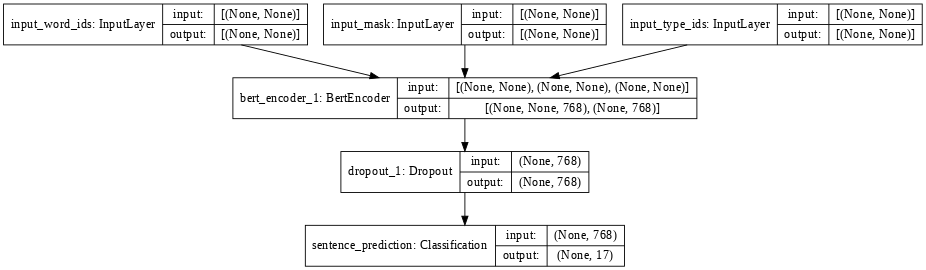

In [34]:
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

import official.nlp.bert.configs

bert_config = bert.configs.BertConfig.from_dict(config_dict)

print("config_dict:")
pprint(config_dict)

import official.nlp.bert.bert_models

bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=OUT_UNITS)

print("Classifier plot:")
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=64)

Encoder plot:


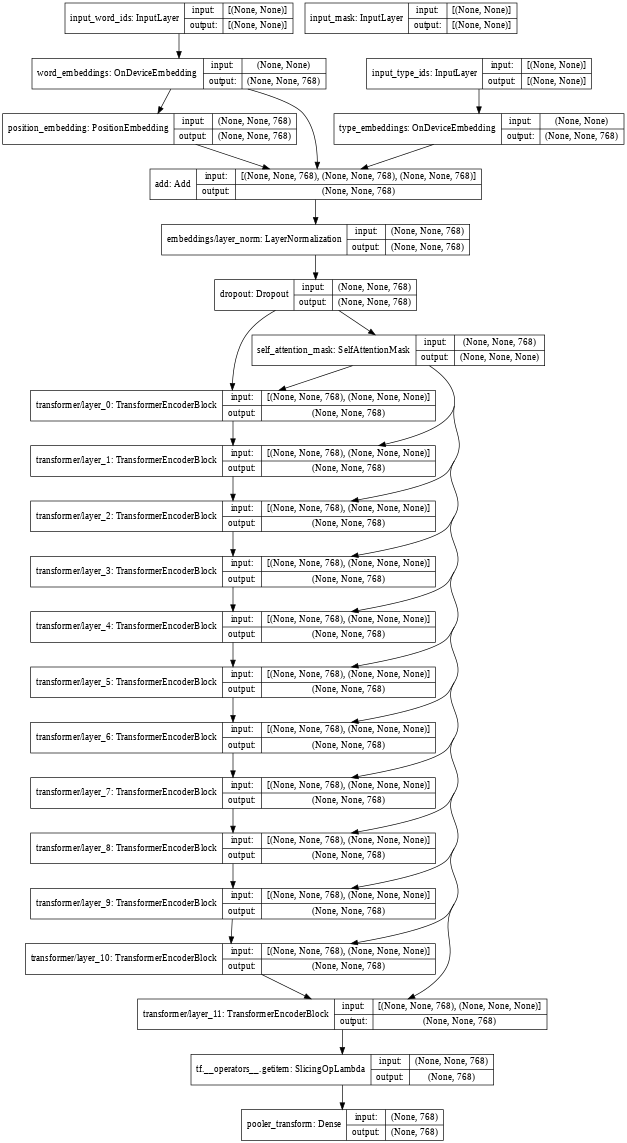

In [35]:
print("Encoder plot:")
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

Aftre playing a while with the downloaded version, I decided that I am not going to use it into my future work since some of the parameters names are modified with each update, so in order to be sure I am using the final version of BERT, fully compatible with `tensorflow` I will stick to whatever is available in `tensorflow_hub`.

Before putting BERT into my model, I'll demonstrate its outputs and how the input can be simulate using my customized preprocess. It will be done based on the TensorFlow Hub model chosen in section "*Selecting and loading the model*".

In [36]:
bert_enc_model = hub.KerasLayer(tfhub_handle_encoder)

The test will be done again on the `validation` dataset, resulted from the visualization used before:

In [37]:
# choosing the first sentence from batched validation set
for (inputs, label_id) in validation: 
  print('Keys           : ', list(inputs.keys()))
  print('Shape Word Ids : ', inputs['input_word_ids'].shape)
  print('Word Ids       : ', inputs['input_word_ids'][0, :12])
  print('Shape Mask     : ', inputs['input_mask'].shape)
  print('Input Mask     : ', inputs['input_mask'][0, :12])
  print('Shape Type Ids : ', inputs['input_type_ids'].shape)
  print('Type Ids       : ', inputs['input_type_ids'][0, :12])
  print('#'*90)
  bert_results = bert_enc_model(inputs)
  print(f'Loaded BERT: {tfhub_handle_encoder}')
  print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
  print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
  print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
  print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')
  print(f'Encoder Outputs Shape:{bert_results["encoder_outputs"][0].shape}')
  print(f'Encoder Outputs Values:{bert_results["encoder_outputs"][0][0, :12]}')
  break

Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (16, 256)
Word Ids       :  tf.Tensor([  101   512 26313 58056 55048 10746 13368 52203 32418 10928 10297 20422], shape=(12,), dtype=int32)
Shape Mask     :  (16, 256)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1], shape=(12,), dtype=int32)
Shape Type Ids :  (16, 256)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0], shape=(12,), dtype=int32)
##########################################################################################
Loaded BERT: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(16, 768)
Pooled Outputs Values:[ 0.12184808 -0.0163886   0.203754   -0.18777439 -0.10683946  0.06027573
  0.17212023  0.0979872  -0.22828776 -0.04825079 -0.01181884 -0.06624751]
Sequence Outputs Shape:(16, 256, 768)
Sequence Outputs Values:[[-0.12188576 -0.16414413 -0.37376097 ...  0.13160148  0.13240221
  -0.2742458 ]
 [-0.01606957 -0.28604206  0.18511228 ...  0.

As demonstrated the BERT model returns a map(dictionary) with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. It may be looked at as an abstraction of embedding on sentences level.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. It represents something as a contextual embedding for every token in a sentence. In fact this what interest us most.
- `encoder_outputs` are the intermediate activations of the **L** Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the `i`-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

The last value of this list (or the `sequence_output`) is the easiest part to be used I am going to use in my model.

But despite the simplicity, in Allamar's blog post called [The illustrated BERT, ELMo and co.](http://jalammar.github.io/illustrated-bert/) from 2018 an improvement in the f1 score is shown for the NER task when the outputs from last four layers are summed up. Other combinations would provide different scoring:

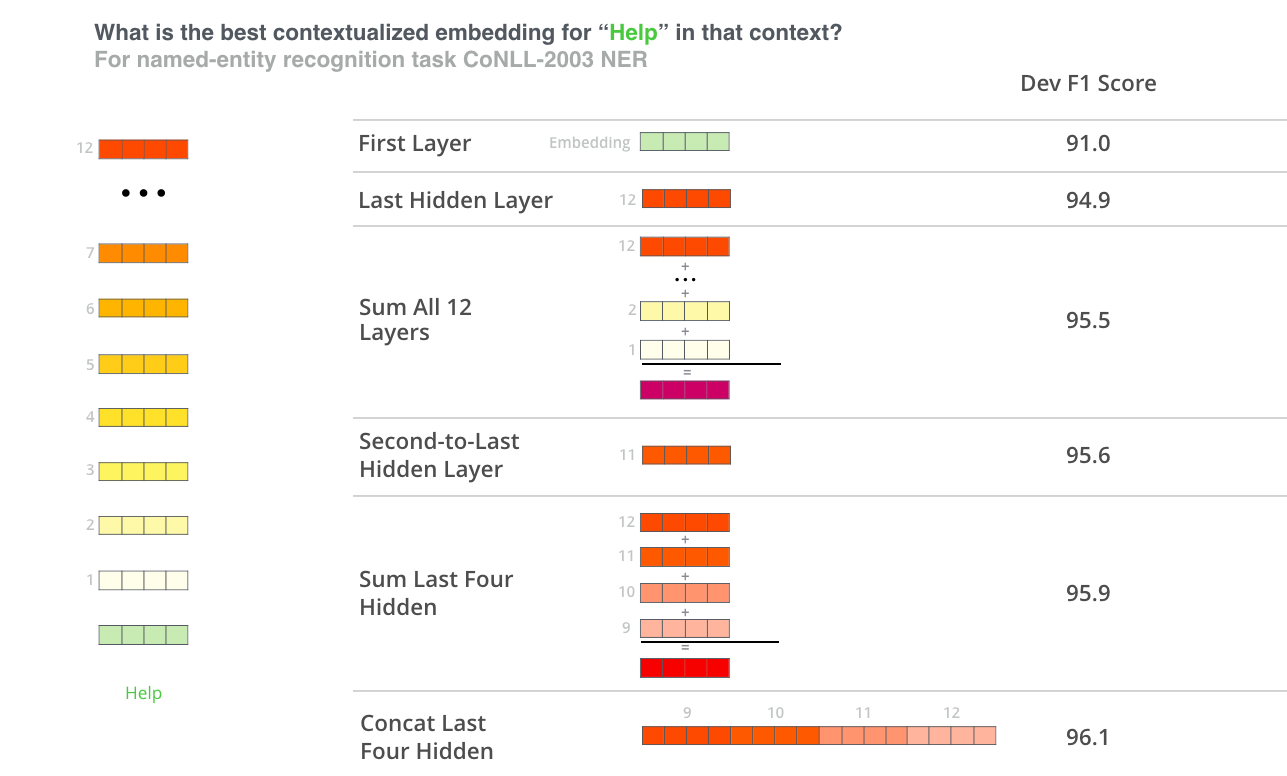

Why is it different? BERT has the capability that each token embedded in a embedding vector is transformed progressively every time it traverse one of the Encoder layers. So at each layer the ebedding layer shows different aspects of how the tokens interact with each other due to the specific construction of Bert layers shown on this 3D image taken from [Peltarion tutorials](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/blocks/multilingual-bert-encoder):


<img src=https://peltarion.com/static/bert_encoder_block_cls_only.svg width = 700>

When creating the model there are other options for dealing with the subwords. In case we would like to use the `valid_ids` inside the model, we have to add a `Lambda` layer with the respective logic to it that will provide only the labels corresponding to the main words or first subwords. In that case the addition of `'X'` label is not needed.

I chose to add this label, so, there is no need to have a `Lambda` layer, even though I have inserted the code required for such case commented inside the model, along with the respective function `_check_valid_output`.

In [38]:
def build_classifier_model(num_classes=OUT_UNITS):
  inp = dict(
      input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
  )

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(inp)['encoder_outputs']

  x1 = tf.keras.layers.Dense(1536, activation='relu', name='dense_1')(outputs[-1])
  x1 = tf.keras.layers.Dropout(rate=0.1)(x1)
  # x1 = tf.keras.layers.Dense(1024, activation='relu', name='dense_1_1')(x1)
  x1 = tf.keras.layers.Dense(544, activation='relu', name='dense_last_1')(x1)
  x1 = tf.keras.layers.Dropout(rate=0.1)(x1)

  x2 = tf.keras.layers.Dense(1024, activation='relu', name='dense_2')(outputs[-2])
  x2 = tf.keras.layers.Dropout(rate=0.1)(x2)
  x2 = tf.keras.layers.Dense(544, activation='relu', name='dense_last_2')(x2)
  x2 = tf.keras.layers.Dropout(rate=0.3)(x2)
  
  x3 = tf.keras.layers.Dense(1024, activation='relu', name='dense_3')(outputs[-3])
  x3 = tf.keras.layers.Dropout(rate=0.1)(x3)
  x3 = tf.keras.layers.Dense(544, activation='relu', name='dense_last_3')(x3)
  x3 = tf.keras.layers.Dropout(rate=0.3)(x3)

  x4 = tf.keras.layers.Dense(1024, activation='relu', name='dense_4')(outputs[-4])
  x4 = tf.keras.layers.Dropout(rate=0.1)(x4)
  x4 = tf.keras.layers.Dense(544, activation='relu', name='dense_last_4')(x4)
  x4 = tf.keras.layers.Dropout(rate=0.3)(x4)

  concat_1 = tf.keras.layers.Concatenate(name = 'concat_1')([x1, x2, x3, x4])
  # concat_1 = tf.keras.layers.Dropout(rate=0.3)(concat_1)

  dense_output = tf.keras.layers.Dense(544, activation='relu', name='dense_last_0')(concat_1)
  dense_output = tf.keras.layers.Dropout(rate=0.1)(dense_output)

  # x_1 = tf.keras.layers.BatchNormalization()(x1)
  # dense_output = tf.keras.layers.BatchNormalization()(dense_output)
  added_1 = tf.keras.layers.Add(name = 'added_1')([x1, dense_output])
  dropout_output = tf.keras.layers.Dropout(rate=0.1)(added_1)

  bn_output = tf.keras.layers.BatchNormalization()(dropout_output)
  final_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(bn_output)

  return tf.keras.Model(inputs=inp, outputs=final_output, name='predictions')

In [39]:
classifier_model = build_classifier_model()

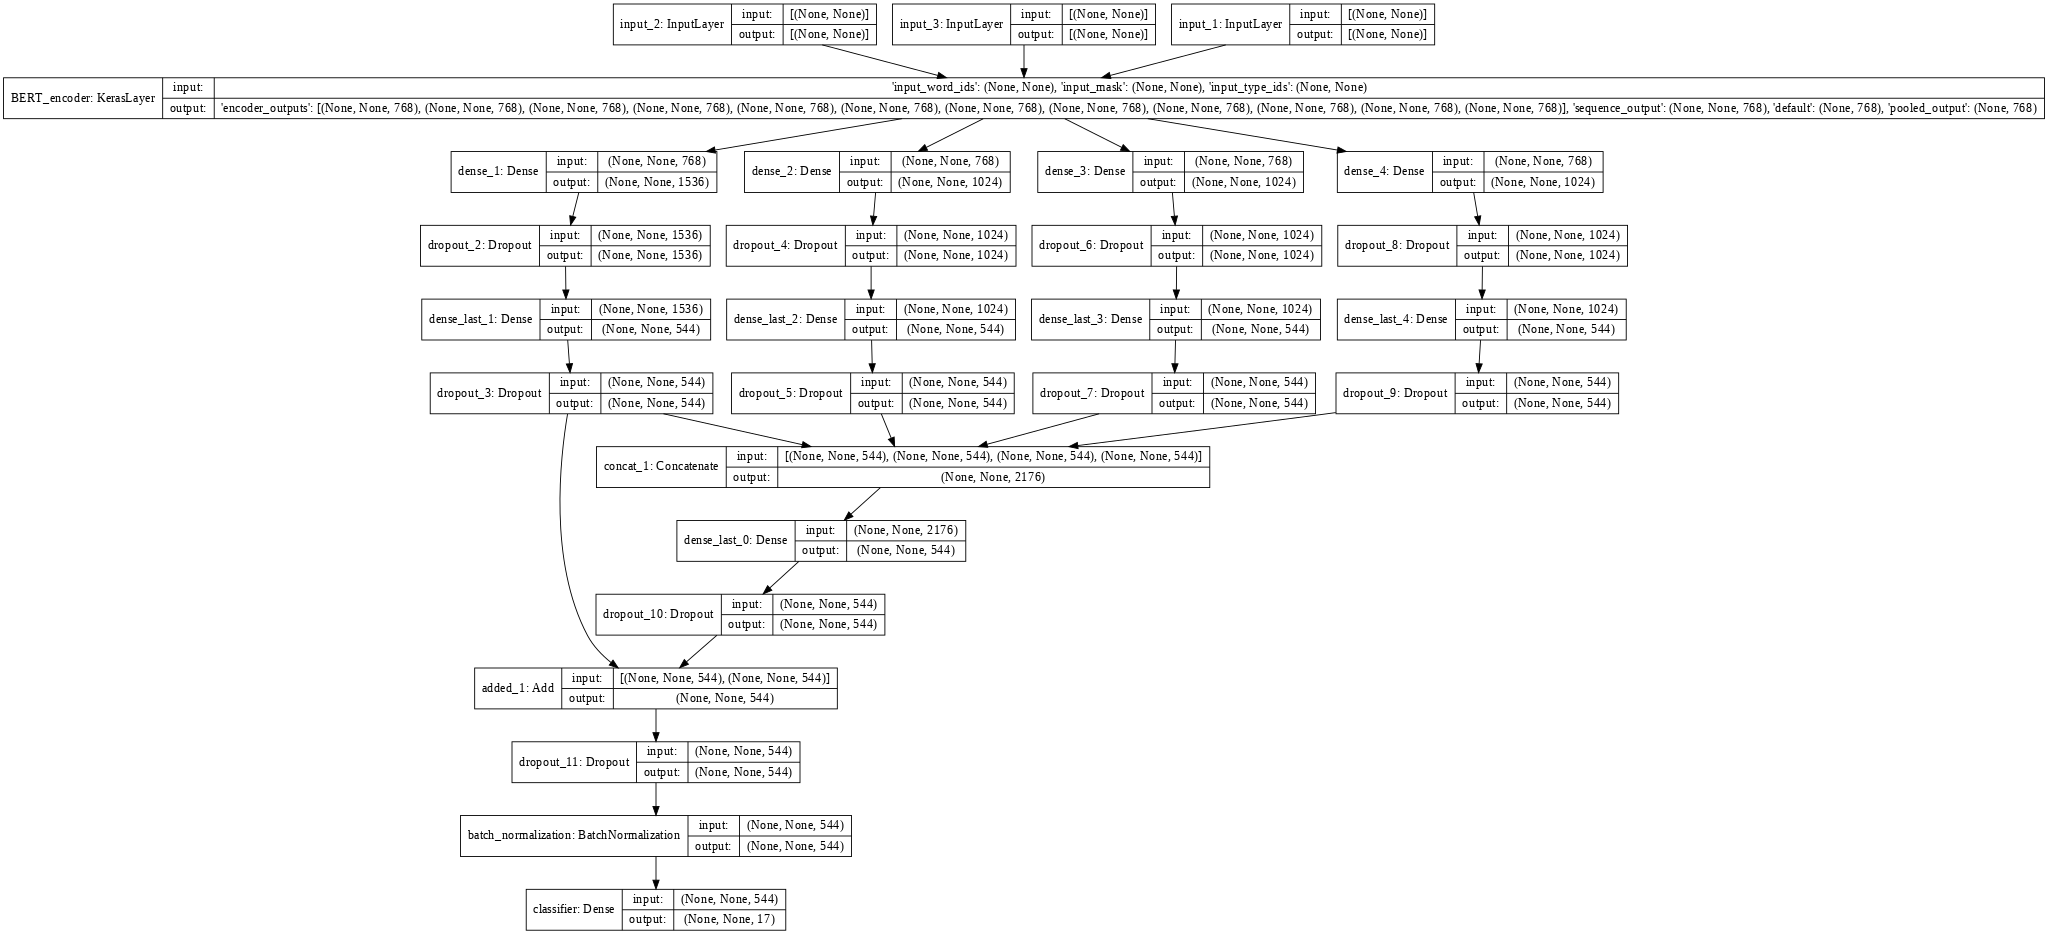

In [40]:
tf.keras.utils.plot_model(classifier_model, show_shapes=True, dpi=64)

There is an option for cases when we search for more flexibility with the inputs and the outputs, but its far more complex. This option uses a class that inherits `tf.keras.Model` (so called *Model Subclassing*). Below you can see its implementation with the additional option of using the `valid_ids` to clear out the outcomes for the subwords. It is not directly applicable, since a sligth modification in the way the inputs are made, specifically `valid_ids` variable, should be implemented in preparation of the data:

In [41]:
class BertNer(tf.keras.Model):

    def __init__(self, num_labels, max_seq_length, bert_model=tfhub_handle_encoder):
        '''
        bert_model : tfhub_handle_encoder
        num_labels : num of tags in NER task
        max_seq_length : max_seq_length of tokens
        final_layer_initializer : default:  tf.keras.initializers.TruncatedNormal
        '''
        super(BertNer, self).__init__()
        
        # defining the Input of the BERT layer
        inp = dict(
            input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids'),
            input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask'),
            input_type_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32, name='input_type_ids'),
        )

        # defining the BERT model encoder
        encoder = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder', trainable=True)

        # BERT model as a layer, based on the last layer 4 layers outcome ('encoder_outputs')
        outputs = encoder(inp)["encoder_outputs"][-4:]
        self.bert = tf.keras.Model(inputs=inp, outputs=outputs, name="BERT_last_layer")
        
        # layer adding last 4 BERT layers
        self.added = tf.keras.layers.Add()

        # BERT initializer_range = 0.02
        initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02)
        
        # adding Lambda function (in case the valid_ids is included as part of the model)
        # self.valid_output = tf.keras.layers.Lambda(self._check_valid_otput)

        # adding default DROPOUT Layer
        self.dropout = tf.keras.layers.Dropout(rate=0.1)
        
        # defining the output Layer
        self.classifier = tf.keras.layers.Dense(
            num_labels, kernel_initializer=initializer, activation='softmax',name='softmax_output', dtype=tf.float32)

    def __call__(self, input_dict, **kwargs):
        enc_outputs = self.bert(input_dict, **kwargs)
        # valid_output = self.valid_output((sequence_output, valid_mask))
        added_output = self.added([enc_outputs[-1], enc_outputs[-2], enc_outputs[-3], enc_outputs[-4]])
        dropout_output = self.dropout(added_output, training=kwargs.get('training', False))
        logits = self.classifier(dropout_output)
        return logits

    @staticmethod
    def _check_valid_output(params):
        sequence_output, valid_mask = params
        valid_output = []
        for i in range(sequence_output.shape[0]):  # shape[0] is batch_size
            empty = 0
            _temp = []
            for j in range(sequence_output.shape[1]):  # shape[1] is max_seq_len
                if (valid_mask[i][j] == 1): 
                    _temp.append(sequence_output[i, j])
                else: 
                    empty += 1
            _temp.extend(empty * [tf.zeros_like(sequence_output[i, j])])
            valid_output.extend([_temp])
        return tf.reshape(tf.stack(valid_output), sequence_output.shape)

In [42]:
# ner = BertNer(OUT_UNITS, MAX_SEQ_LENGTH)

### Set up the optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). As described in the prodecure of [Fine-Tuning Bert in Tensorflow Tutorials](https://www.tensorflow.org/official_models/fine_tuning_bert#set_up_the_optimizer): "BERT adopts the Adam optimizer with weight decay (aka "AdamW"). It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0."

In [43]:
# set_up steps

steps_per_epoch = (train_size // BATCH_SIZE) + 1  # operation should be ceiling

num_train_steps = steps_per_epoch * EPOCHS

warmup_steps = int(WARM_UP_PROPORTION * num_train_steps)

print(f"Number of training steps: {num_train_steps},")
print("out of which warm-up steps:", warmup_steps)

Number of training steps: 1100,
out of which warm-up steps: 110


In [44]:
validation_steps = val_size // BATCH_SIZE

print("And validation steps", validation_steps)

And validation steps 105


It is commonly observed that a monotonically decreasing learning rate, whose degree of change is carefully chosen, results in a better performing model (source [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay)). The PolynomialDecay schedule applies a polynomial decay function to an optimizer step, given a provided initial_learning_rate, to reach an end_learning_rate in the given decay_steps. 

The base learning rate schedule used here is a linear decay to zero over the training run, visible also on the graph below :

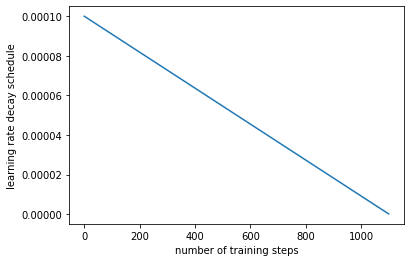

In [45]:
decay_schedule  = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=LEARNING_RATE,
                                                                 decay_steps=num_train_steps,
                                                                 end_learning_rate=0.0)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])
plt.xlabel('number of training steps')
plt.ylabel('learning rate decay schedule')
plt.show()

Using `nlp.optimization` `WarmUp` class, the definition of the warm-up schedule can be demostrated on the following figure:

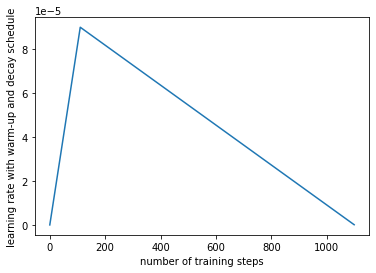

In [46]:
warmup_schedule = WarmUp(initial_learning_rate=decay_schedule(warmup_steps),
                         decay_schedule_fn=decay_schedule,
                         warmup_steps=warmup_steps)
  
plt.plot([warmup_schedule(n) for n in range(num_train_steps)])
plt.xlabel('number of training steps')
plt.ylabel('learning rate with warm-up and decay schedule')
plt.show()

It warms up to the `initial_learning_rate` following the learning rate level at the moment the decay schedule calculates it depending on the number of training steps.

Based on the above calculations, the optimizer can be created using three equal ways: 
- using `optimization.create_optimizer` function,
- using `AdamWeightDecay` class from same `official.nlp` module,
- using `AdamW` class from `tensorflow_addons` module.

I will use the `create_optimizer` function despite it doesn't really matter, but it is the most simple option in terms of parameters provided.

In [47]:
optimizer_f = optimization.create_optimizer(
      init_lr=LEARNING_RATE,
      num_train_steps=num_train_steps,
      num_warmup_steps=warmup_steps,
      optimizer_type='adamw')

In [48]:
type(optimizer_f)  # official.nlp.optimization.AdamWeightDecay

official.nlp.optimization.AdamWeightDecay

In [49]:
optimizer = AdamWeightDecay(
            learning_rate=warmup_schedule,
            weight_decay_rate=WEIGHT_DECAY,
            epsilon=ADAM_EPSILON,
            exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])
# default values: beta_1=0.9, beta_2=0.999,

In [50]:
type(optimizer)  # official.nlp.optimization.AdamWeightDecay

official.nlp.optimization.AdamWeightDecay

In [51]:
optimizer_ = AdamW(weight_decay=WEIGHT_DECAY,
                   learning_rate=decay_schedule(warmup_steps),
                   epsilon=ADAM_EPSILON)

In [52]:
type(optimizer_)  # tensorflow_addons.optimizers.weight_decay_optimizers.AdamW

tensorflow_addons.optimizers.weight_decay_optimizers.AdamW

### Select loss and metrics

Select metrics to measure the loss and the accuracy of the model is the next step. These metrics accumulate the values over epochs and then print the overall result. 

In general the NER task is always dealing with highly imbalanced data - it is a fact that in such datasets most tokens are backgrounded with tagging class 'O'. I was visible in the short analysis made in the beginning. It is not that surprising. In very popular datasets in English the number of tokens with tagging class 'O' is from 5 times as many as those with entity labels (for the CoNLL03 dataset) up to 8 times (for the OntoNotes5.0 dataset).

Without balancing the labels, the learning process tends to converge to a point that strongly biases towards class with the majority label. The huge number of easy examples tends to overwhelm the training, making the model not sufficiently learn to distinguish between positive examples and hard-negative examples.

Saying the above, the performance of the NER system is commonly measured by the F1-score. The reason is that both false negatives and false poitives are important, especially when we deal with "imbalanced" data. F1-score provides some balance between precision and recall. Output range is between `[0, 1]`.
$$F_1 = 2 * \frac{\textrm{precision} * \textrm{recall}}{\textrm{recision} + \textrm{recall}}$$

The more general F-score is $F_{\beta}$ where $\beta$ determines the weigth given to the precision and recall and is equal to it when $\beta = 1$:
$$F_{\beta} = (1 + \beta^2) * \frac{\textrm{precision} * \textrm{recall}}{\beta^2 \cdot \textrm{precision} + \textrm{recall}}$$

In the `tensorflow_addons.metrics` module `F1Score` exists as ready-to-use option. In this module, similar to others, there is a parameter which defines its behaviour, called `average`, which can have the following state:

- `micro`: True positivies, false positives and
    false negatives are computed globally.`

- `macro`: True positivies, false positives and
    false negatives are computed for each class
    and their unweighted mean is returned.

- `weighted`: Metrics are computed for each class
    and returns the mean weighted by the
    number of true instances in each class.

Unfortunately, this F1-score taken from `tensorflow_addons.metrics` is unable to deal with '*sparced*' outcome coming from the last layer which uses 'softmax' activation. It accepts only outcome with similar shape as the input. For that I will need to create a specific training function. Instead, I could create a custom specific metric. 

This custom F1-score will compute using `average = 'micro'`. It is not as big problem, as in general the results will be higher that averaging of type `'macro'`, but the trend for f1-score will be the same. It is not ideal situation, but there is another speciality that makes it directly uncomaparable with the *F1-score* found in the papers. At this stage the custom F1 will include the correctness also for the 'X' class and for the 'padding' parts. This is not the case in the papers. Lately, on test set for instance, by using the `valid_ids` variable as mask, it will be possible to check the final f1-score that is comparable with the one seen in all the papers on this suject. For the moment this custom score will serve only as orientation, since the `accuracy` metric might show too high number based on the biggest class only.

In [53]:
class CustomF1Score(tf.keras.metrics.Metric):
    """
    F_beta = (1 + beta^2) * precision * recall / (beta^2 * precision + recall)
    
    The function is implemented in a way to perform only 'micro' averaging 
    on the data as it doesn't take into account the number of classes.

    Args:
        beta: Determines the weight of precision and recall
            in harmonic mean. Default value is 1.0.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.
    """

    def __init__(self, name="custom_f1_score", beta = 1.0, dtype = None):
        super(CustomF1Score, self).__init__(name=name, dtype=dtype)
        self.beta = beta
        self.true_positives = self.add_weight("true_positives", initializer="zeros")
        self.false_positives = self.add_weight("false_positives", initializer="zeros")
        self.false_negatives = self.add_weight("false_negatives", initializer="zeros")
        # self.average = 'micro'

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.argmax(y_pred, -1), tf.int32)
        y_true = tf.cast(y_true, tf.int32)
        
        yx = y_true == y_pred  # True for all true_positives
        not_yx = tf.logical_not(yx) # True for all true_negatives

        # casting booleans to int to make the computations with 1
        yx = tf.cast(yx, tf.int32)
        not_yx = tf.cast(not_yx, tf.int32)

        #calculations of TP, FP, FN
        true_positives = tf.cast(yx, tf.float32)
        false_positives = tf.cast((1 - yx), tf.float32)
        false_negatives = tf.cast((1 - not_yx), tf.float32)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            true_positives = tf.multiply(true_positives, sample_weight)
            false_positives = tf.multiply(false_positives, sample_weight)
            false_negatives = tf.multiply(false_negatives, sample_weight)

        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)
        
        self.true_positives.assign_add(tf.reduce_sum(true_positives))
        self.false_positives.assign_add(tf.reduce_sum(false_positives))
        self.false_negatives.assign_add(tf.reduce_sum(false_negatives))        

    def result(self):
        # calculation of precision, recall and f_beta
        precision = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_positives
        )
        recall = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_negatives
        )

        mul_value = precision * recall
        add_value = (tf.square(self.beta) * precision) + recall
        mean = tf.math.divide_no_nan(mul_value, add_value)
        f1_score = mean * (1 + tf.math.square(self.beta))

        return f1_score

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)

When using the `softmax` activation for the last layer of our model, the objective loss that should be applied is the `'sparse_categorical_crossentropy'`:

In [54]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
# train_loss = tf.keras.metrics.Mean(name='loss')
# train_f1_metric = F1Score(OUT_UNITS, average='macro')

# eval_loss = tf.keras.metrics.Mean(name='loss')
# eval_f1_metric = F1Score(OUT_UNITS, average='macro')

Based on relatively recent studies found in [**Dice Loss for Data-imbalanced NLP Task**](https://arxiv.org/pdf/1911.02855v3.pdf), it turns out that using a dice loss instead of space categorical cross-entropy loss used in such multi-class problems I could achieve a bit better score. 

From one side the dice loss is a soft version of F1-score - it is the harmonic mean of precision and recall. It attaches equal importance to false positives (FPs) and false negatives (FNs) and is thus more immune to data-imbalanced datasets. But it is also inspired by the focal loss, from where it takes each training example with a weight in proportion to (1 − p). At the end of this paper the recommended implementation of the dice loss follow the equation:

$$DSC(x_i) = \frac{2(1 - p_i)^\alpha p_i \cdot y_i + \gamma}{(1-p_i)^\alpha p_i + y_i + \gamma}$$

In [55]:
# adaptive Dice Loss
class ComputeDscLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.6, reduction='auto', gamma=1.0, name='compute_dsc_loss'):
        """
        Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
        ("Dice Loss for Data-imbalanced NLP Tasks" paper)
        params:
            y_true: shape `(batch_size)` where each value is in [0, C - 1]
            y_pred: shape `(batch_size, max_seq_len, C)` where `C` is the number of classes.
            alpha (float): a factor to push down the weight of easy examples, in the range [0, 1], default to 0.6
            gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
            reduction (string): Specifies the reduction to apply to the output:
                ``'none'``: the unreduced vector loss is passed to the optimizer
                        but the reported loss will be a scalar value;
                ``'auto'``: defaults to SUM_OVER_BATCH_SIZE, which is scalar SUM
                        divided by number of elements in losses, default value; 
                ``'sum'``: scalar sum of weighted losses.
        """
        super().__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma

        if reduction == 'none':
          self.reduction == tf.keras.losses.Reduction.NONE
        elif reduction == 'auto':
          self.reduction == tf.keras.losses.Reduction.AUTO
        elif self.reduction == 'sum':
          self.reduction == tf.keras.losses.Reduction.SUM
        else:
          raise NotImplementedError(f"Reduction `{reduction}` is not supported.")

    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, [-1, y_pred.shape[-1]])  # shape=(4096, 17)
        y = tf.expand_dims(tf.reshape(y_true, shape=(-1, )), axis=1)  # shape=(4096, 1), dtype should be int
        # additional check
        y = tf.cast(y, dtype=tf.int32)
        # using `tf.gather_nd` on `batch_dims = 1` should take only the probabilities for the correct labels
        probabilities = tf.gather_nd(y_pred, y, batch_dims=1)  # tf.Tensor: shape=(4096,), dtype=dtype of y_pred
        probabilities_with_factor = tf.pow(1 - probabilities, self.alpha) * probabilities  #  shape=(4096,)
        dsc_loss = 1 - (2 * probabilities_with_factor + self.gamma) / (probabilities_with_factor + 1.0 + self.gamma)  # shape=(4096,)
        return dsc_loss

In [56]:
# # unsuccesfull trial with Tversky index calculation and function
# def dice_coef(y_true, y_pred, loss_type):

#     y_pred_f = tf.cast(tf.argmax(y_pred, axis=-1), dtype=float)
#     y_true = tf.cast(y_true, dtype=float)
#     intersection = tf.reduce_sum(y_true * y_pred_f)

#     if loss_type == 'jaccard':
#         union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true))

#     elif loss_type == 'sorensen':
#         union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true)
    
#     return (2. * intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

# # loss functions must only take (y_true, y_pred) as parameters. So we need a separate function that returns another function
# def dice_loss(loss_type='sorensen'):
#     def dice(y_true, y_pred):
#         return 1 - dice_coef(y_true, y_pred, loss_type)
#     return dice

# d_loss = dice_loss()

Unfortunately, after many experiments with this loss function, as it can be seen at the end, the results were more than disappointing. It might be linked with an error in the calculation, despite the formulas inside the paper were strictly followed. It might be successfully used in a version where there is no additional "easy" label as the artificially added 'X' on top... Nevertheless, no matter the hyperparameters tuned, with this loss, the outcome of f1_score was below 0.5, which automatically removed it as an option and the `'sparse_categorical_cressentropy'` loss remained as the only option.

### Training the model

When training the model usign the class `BertNer` it can be done 2 ways - either by overriding the function `train_step(self, data)` inside the class, or creating it separately. The advancement for the first option is that consequently, I could use `.fit()` as usual. But I have left below the code for the second option and because the same is used for the validation, I called it `train_eval_step`.

This `train_eval_step` function will be responsible on each epoch to:
1. iterate over each example in the training Dataset grabbing its features (x) and label (y).
2. Using the example's features, make a prediction and compare it with the label. To be able to compare it correctly the label_mask shouls be applied.
3. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use the optimizer to update the model's variables.

In [57]:
# def train_eval_step(input_dict, 
#                     label_ids, 
#                     loss_obj=loss_obj,
#                     loss=train_loss,
#                     score=train_f1_metric, 
#                     training=False):

#   with tf.GradientTape() as tape:
#     logits = ner(input_dict, training=training)
#     # logits.shape = batchsize, max_seq_length, num_labels
#     scce_loss = loss_obj(label_ids, logits)

#   if training:
#     gradients = tape.gradient(scce_loss, ner.trainable_variables)
#     optimizer_f.apply_gradients(zip(gradients, ner.trainable_variables))

#   loss(scce_loss)
#   print("Loss :", loss.result(), "Training:", training)
#   # score.update_state(label_ids, tf.argmax(logits, -1))

After creating it, the real training starts using a for loop for each `EPOCHS`. The loss and metric results are printed at the end of each epoch.

In [58]:
# for epoch in range(EPOCHS):
#   train_loss.reset_states()
#   train_f1_metric.reset_states()
#   eval_loss.reset_states()
#   eval_f1_metric.reset_states()
  
#   # Training loop - using batches
#   print("=========================Training step:==============================")
#   for i, (input_dict, label_ids) in enumerate(train_data):
#     train_eval_step(input_dict, label_ids, training=True)

#   print("========================Evaluation step:=============================")
#   for j, (input_dict, label_ids) in enumerate(val_data):
#     train_eval_step(input_dict, label_ids, loss=eval_loss, score=eval_f1_metric)
      
#   print(
#       f'Epoch {epoch + 1}, '
#       f'loss : {train_loss.result()}, '
#       # f'f1-score: {train_f1_metric.result():.4f}, '
#       f'Validation loss: {eval_loss.result()}, ')
#       # f'Validation f1-score: {eval_f1_metric.result()}')

In [59]:
# tf.keras.backend.clear_session()

in order to use more advanced option, including also the `callbacks`, the main experiments were conducted based on the `classifier_model` created earlier. It compiles using `.compile()` function. I will use as metric both `accuracy` and my `CustomF1Score`.

In [60]:
classifier_model.compile(optimizer=optimizer_f,
                         loss=loss_obj,
                        #  loss=ComputeDscLoss(),
                        #  loss=d_loss,
                         metrics=[
                                  tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy', dtype=tf.float32), 
                                  CustomF1Score(),
                                  ], 
                         )

Below, I show the summary of the most successful model (in terms of f1_score):

In [61]:
classifier_model.summary()

Model: "predictions"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  177853441   input_2[0][0]                    
                                                                 input_3[0][0]          

Using `BatchNormalization()` increases the number of non-trainable parameters. The number of trainable parameters is still huge. When processing a '*fine-tunning*' all the BERT's parameters are also participating actively in the training. In general all these params are part of 219 variable (as shown below), out of which 200 belong to BERT itself.

In [62]:
len(classifier_model.trainable_variables)

221

Before proceeding with `.fit()` I need to decide on few parameters. Now having only 2 epochs of fine-tuning and the `learning rate` using a decay schedule endong at 0.0, I expect that at some points there will be no visible improvements.  To stop the training at this point I could use the `EarlyStopping` callback. Unfortunately, this callback is done in a way to observe only the epochs. That is why if I want to use it, I will have to create my own class that implements `on_batch_end` function (as the name of one of the function to be overwritten indicates). It is possible to find ready-to-use code as an answer on the question in [StackOverflow](https://stackoverflow.com/questions/57618220/how-we-can-define-early-stopping-for-keras-to-check-after-each-batch-not-entire). It copycats the original `EarlyStopping` with all its params monitoring the batches.

Using this custom `EarlyStopping` callback based on training metrics is a very sensitive topic, since the decreasing `learning rate` can simply push my loss to the extreme of the local or hopefully global minumum, and any rush in stopping the process earlier can produce a drawback instead of improvement.

There are two other callbacks that I will use instead:
- `TensorBoard` callback writing the metrics each 25 mini-batches, and
- `ModelCheckpoint` to save the weights as I am working in Google Colab after all.

In [63]:
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/tmp/checkpoint'

my_callbacks = [
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
    #                                    save_weights_only=True,
    #                                    monitor='accuracy',
    #                                    mode='max',
    #                                    save_freq=100),
    tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Colab Notebooks/logs', 
                                   write_graph=True,
                                   update_freq=25),
]

In [64]:
!rm -rf '/content/drive/MyDrive/Colab Notebooks/logs'

In [ ]:
print(f'Fine tuning {tfhub_handle_encoder} model')

history = classifier_model.fit( train_data,
                                # steps_per_epoch=(steps_per_epoch + 1)//2,  # without it I go through the whole training set
                                epochs=EPOCHS,
                                validation_data=val_data,
                                # validation_steps=validation_steps,  # without it I go through the whole validation set
                                callbacks=my_callbacks
                               )

Fine tuning https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3 model
Epoch 1/2
550/550 [==============================] - 659s 1s/step - loss: 0.5588 - accuracy: 0.8503 - custom_f1_score: 0.6486 - val_loss: 0.0096 - val_accuracy: 0.9973 - val_custom_f1_score: 0.6658
Epoch 2/2
511/550 [==========================>...] - ETA: 43s - loss: 0.0056 - accuracy: 0.9986 - custom_f1_score: 0.6663

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/logs'

In [ ]:
def transf_X_to_OTHtag(predictions, to_tag='O'):
  """
  manual transformation of 'X' to 'O' or other previous tag in labels
  params: 
        predictions: list with predicted tags
        to_tag: default 'O', but could be some other tag
                if 'previous' than assigns ths tag that preceeds the tag
                changing the prefix to 'I-' if needed
  """
  for i, y in enumerate(predictions):
    try:
      while True:
        idx = y.index('X')
        if to_tag == 'previous':
          to_tag = predictions[i][idx - 1]
          if to_tag.startswith('B'):
            to_tag = 'I' + to_tag[1:]
        predictions[i][idx] = to_tag
    except ValueError:
      continue
  return predictions

In [ ]:

def decode_tags(nd_array, valid_ids, decode_label_map=decode_label_map, to_tag='O'):
  """
  decoding function using the dictionary translating numbers to valid labels
  by removing all subwords and padding based on the inserted valid_ids
  if still padding met -> automatic translation as 'O'
  params:
          nd_array: array in format ndarray with labels/prediction
          valid_ids: tensor, containing the valid_ids
          decode_label_map: dictionary with correct mapping of labels vs index
          to_tag: ['O', 'previous'] Replace errors in predictions: 'X', 0 (padding)
                  '[SEP]', '[CLS]' with 'O' or previous tag. Default to previous
  """
  if to_tag not in ['O', 'previous']:
    raise ValueError(f'"to_tag" value of {to_tag} not supported. \
                        You have to choose between "O" and "previous"')
  if to_tag == 'previous':
    temp = [
            [decode_label_map[i] if i not in [0, 15, 16] else 'X' 
              for i in tf.boolean_mask(tag_id, valid_id).numpy()] 
              for tag_id, valid_id in zip(nd_array, valid_ids)
            ]
    return transf_X_to_OTHtag(temp, to_tag=to_tag)
  return [
          [decode_label_map[i] if i not in [0, 2, 15, 16] else to_tag 
           for i in tf.boolean_mask(tag_id, valid_id).numpy()] 
           for tag_id, valid_id in zip(nd_array, valid_ids)
          ]

In [ ]:
def predictions_postprocess(model, dataset, valid_ids, return_decoded=True):
  """
  preparing the labels and predictions, based on the inserted model,
  in same shape as valid_ids
  Returns: labels and predictions as ndarrays when 'return_decoded' is False
           or decoded labels and prediction when 'return decoded' is True
  """
  labs , preds = None, None
  for batch, (test_inp, test_labels) in enumerate(dataset):
    predictions = model(test_inp)
    pred = tf.argmax(predictions, axis=2)
    if batch == 0:
      labs = test_labels
      preds = pred
    else:
      labs = tf.experimental.numpy.append(labs, test_labels, axis=0)
      preds = tf.experimental.numpy.append(preds, pred, axis=0)
    assert labs.shape == preds.shape
  assert labs.shape == valid_ids.shape

  if return_decoded:
    # decoding ids to true labels
    y_true = decode_tags(labs, valid_ids)  #, to_tag='previous')
    y_pred = decode_tags(preds, valid_ids)  #, to_tag='previous')
    return y_true, y_pred

  return labs, preds

In [ ]:
y_true, y_pred = predictions_postprocess(classifier_model, test_data, test_valid_ids)
# y_true, y_pred = predictions_n_labels_postprocess(new_model, test_data, test_valid_ids)

fscore = f1_score(y_true, y_pred, average='macro')
pscore = precision_score(y_true, y_pred)
rscore = recall_score(y_true, y_pred)
print(' - f1: {:04.2f}'.format(fscore * 100))
print(' - precision: {:04.2f}'.format(pscore * 100))
print(' - recall: {:04.2f}'.format(rscore * 100))
print(classification_report(y_true, y_pred, digits=4))

In [ ]:
raise NotImplementedError("Stop here!")

In [ ]:
for k, v in history.history.items():
  print(k, v)

Testing the model on the prepared pre-processed test dataset.

In [ ]:
print("Evaluate on test data")
result_test = classifier_model.evaluate(test_data)
dict(zip(classifier_model.metrics_names, result_test))

In [ ]:
print("Evaluate on validation data")
result_val = classifier_model.evaluate(val_data)
dict(zip(classifier_model.metrics_names, result_val))

### Saving the model

After saving the model, the best version of all the experiments based on "real" f1-score shown below is saved by first defining the `path + desired name`.

In [ ]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/trained_model/'

bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'trained_{bert_type}'
# saved_model_name = f'trainedv2_{bert_type}'

saved_model_path = os.path.join(model_save_path, saved_model_name)

The actual saving can easily happen then.

In [ ]:
print(f'Saving {saved_model_path}')

!mkdir -p model_save_path

# Save everything 
# save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')  # save even the variables from TPU memory
classifier_model.save(saved_model_path)  # , options=save_options)

### Loading and testing the model

To restore the model we use the same `path + saved model name` where the best model is saved and then load it in new model variable.

In [ ]:
new_model = tf.saved_model.load(saved_model_path)

Now, I will make a visualization on the test dataset. To use it I'll have to create a function that I'll name `predictions_postprocess`. (Maybe the name is not the perfect name, but as this stage is "post-"training, it will do the job.) 

This function will rely on another function for decoding the predicted ids, which will also remove any errors in the predictions: which is the case of wrongly predicted padding (with id of 0), or labels like artificially inserted 'X', '[CLS]' or '[SEP]' that should not appear in final version of prediction after the valid_ids mask is applied.

I have prepared an optional parameter, thanks to which, I can visualize what comes out as prediction and as original labels to compare:

In [ ]:
labs, preds = predictions_postprocess(classifier_model, test_data, test_valid_ids, return_decoded=False)

for label, pred, valid_id in zip(labs, preds, test_valid_ids):
  sent_coded = tf.boolean_mask(label, valid_id)
  pred_coded = tf.boolean_mask(pred, valid_id)
  sent_coded = [decode_label_map[i] for i in sent_coded.numpy()]
  pred_coded = [decode_label_map[i] for i in pred_coded.numpy()]
  print("Original labels: ", sent_coded)
  print("Predicted labels:", pred_coded)
  break

Using the advantage of having correct labels for each word in the initial file 'test_NER_BG.txt' and consquently in the dataset, here I can show the `f1-score`, `precision_score`, `recall_score` and the whole `classification_report` taken from [`seqeval.metrics`(https://github.com/chakki-works/seqeval) module.

In fact this is the method used experimentally to evaluate the different architectures of the `classifier_model`. As I train it only over 2 `epochs` it was not easy to figure out from the results whether there is a problem of '*bias*' or '*variation*'.

So, for instance, for a model consisting of simple structure of `BERT classifier` - addition of last 4 `encoder_outputs` followed by `Dropout` of rate 0.1 and a '`softmax`' classifier, using the `SCCE` loss, the `f1_score` with `'macro'` averaging is of 76.78. Changing the droupout rate to 0.3 will lower `f1_score` to 76.24, while dropout rate of 0.2 will result in better `f1_score` of 77.07. That meant that it is more a question of '*bias*' problem, than of '*variation*'.

In the same time with same simple structure, but taking directly the last layer or the `sequence_output` shows just a bit better result but a same conclution can be made with regards of the dropout rate and '*bias*'/'*variation*' ratio: 
- rate of 0.1 -> `f1_score` of 77.95,
- rate of 0.2 -> `f1_score` of 77.32.

This is also how I figured out that usage of `dice loss` is not performing well: with simple structure above providing best results , with `dice loss` the `f1_score` is only 28.42. By complicating the architecture, the results using `dice loss` were getting worse. The `accuracy` results were not good either. So, I decided to abondon `dice_loss` at this stage and keep SCCE loss for the model for now.

On the other side complicating the architecture using `sparsed_categorical_crossentropy` loss improved the results a lot.

Following Allamar's blog, there were numerous trials using `Add` layer or `Concatenate` layer of the last four layers of BERT. To these outputs a `Dense` layer was added followed by `Dropout`. This increased the `f1_score` result above 80%, but none of the experiemnts went above 86-87%.

I had to complicate the architecture further, but that also increased the number of parameters of the model, making it a bit slower.

To increase the number of trainable parameters, each of the last four layers outputs has been connected to two dense layers, their outputs were given to the layers performing an `Add` or a `Concatenate` operations. This increase the `f1-score` to 88% and above.

Observing the `classification_report` of all these trials, it was obvious that the hardest labels were those corresponding to **juridical, organizational** and **product** terms. Based on the SOTA results, I accepted that the irreducible error of this task is of 2 - 3%. Unfortunately, by adding data to the datasets by myself, as not having the appropriate knowledge in the field and also having in mind some dismbiguity in the juridical data in general, I estimate that I have induced additional variation in the data (train, validation and test data) of 2 - 3%. Saying all that, I would accept that the maximum f1_score (with macro averaging) would be at max 94 - 96%.

Having in mind the above analysis on *scores* I continued with the experiments. At the end I came up to two different architectures showing relatively good results:

1. 

 1024

 0.1
 
 768
 
 0.3
 
 Concat 
 
 768
 
 0.2
 
 Concat x1
 
 0.2
 
 BN
 
 - f1: 91.99
 - precision: 89.35
 - recall: 94.79
              precision    recall  f1-score   support

         EVT     0.9926    0.9712    0.9818       139
         LAW     0.8885    0.9506    0.9185       729
         LOC     0.9824    0.9892    0.9858      1016
         ORG     0.8172    0.8930    0.8534       701
         PER     0.9551    0.9926    0.9735       407
         PRO     0.7445    0.8789    0.8061       388

   micro avg     0.8935    0.9479    0.9199      3380
   macro avg     0.8967    0.9459    0.9199      3380
weighted avg     0.8977    0.9479    0.9216      3380

2.

 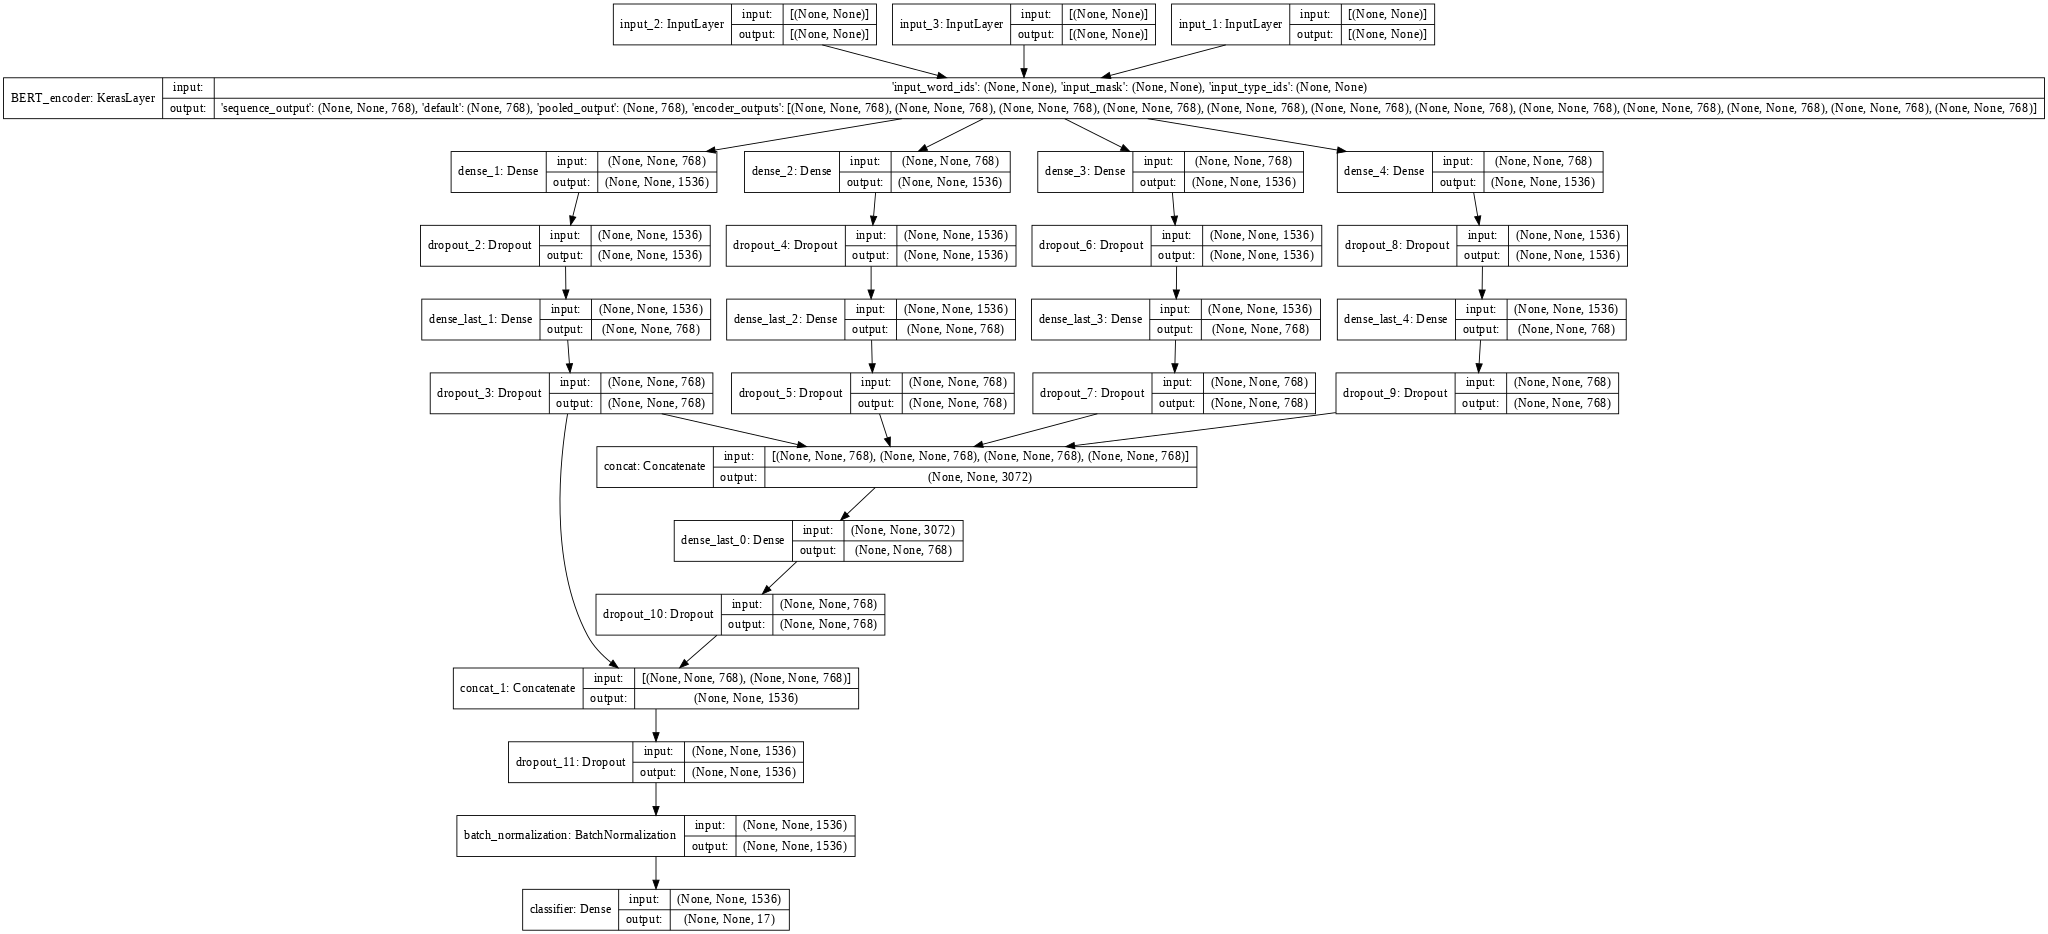

 - f1: 90.89
 - precision: 88.81
 - recall: 94.14
              precision    recall  f1-score   support

         EVT     0.9853    0.9640    0.9745       139
         LAW     0.9039    0.9547    0.9286       729
         LOC     0.9882    0.9852    0.9867      1016
         ORG     0.8283    0.8944    0.8601       701
         PER     0.9220    0.9877    0.9537       407
         PRO     0.6837    0.8299    0.7497       388

        micro avg    0.8881    0.9414    0.9140      3380
        macro avg    0.8852    0.9360    0.9089      3380
        weighted avg 0.8938    0.9414    0.9162      3380

For my task, the most important indexes are the scores linked with '*LAW*' labels. 

######################################################################

each of the last 4 encoder has been passed through a Dense layer with 1024 units, relu activation, than another Dense with 544 units, relu activation, than dropout with 0.2. Than after their dropout are all summed up and the output is given to Dropout 0.2 than 1 BatchNormalization. Loss SCCE.
 - f1: 91.65
 - precision: 89.40
 - recall: 94.59
              precision    recall  f1-score   support

         EVT     0.9854    0.9712    0.9783       139
         LAW     0.8975    0.9492    0.9227       729
         LOC     0.9901    0.9843    0.9872      1016
         ORG     0.8289    0.8987    0.8624       701
         PER     0.9091    0.9828    0.9445       407
         PRO     0.7424    0.8763    0.8038       388

        micro avg    0.8940    0.9459    0.9192      3380
        macro avg    0.8922    0.9438    0.9165      3380
        weighted avg 0.8983    0.9459    0.9208      3380

each of the last 4 encoder has been passed through a Dense layer with 1024 units, relu activation. Than are all summed up and the output is given to Dropout 0.2 than 1 Dense 544 units, relu and dropout 0.2 and BatchNormalization. Loss SCCE.

 - f1: 90.89
 - precision: 88.54
 - recall: 93.93
              precision    recall  f1-score   support

         EVT     0.9784    0.9784    0.9784       139
         LAW     0.8739    0.9410    0.9062       729
         LOC     0.9931    0.9852    0.9891      1016
         ORG     0.8132    0.8944    0.8519       701
         PER     0.9330    0.9926    0.9619       407
         PRO     0.7133    0.8273    0.7661       388

        micro avg    0.8854    0.9393    0.9116      3380
        macro avg    0.8842    0.9365    0.9089      3380
        weighted avg 0.8901    0.9393    0.9135      3380

 each of the last 4 encoder has been passed through a Dense layer with 1024 units, relu activation. Than are all summed up and the output is given to Dropout 0.2 than 2 Denses with 1024 and 544 units, relu and dropout 0.2 for the first and 0.1 for the second and again BatchNormalization for last Dense only. Loss SCCE.
 - f1: 90.40
 - precision: 87.49
 - recall: 93.93
              precision    recall  f1-score   support

         EVT     0.9926    0.9712    0.9818       139
         LAW     0.8462    0.9438    0.8923       729
         LOC     0.9882    0.9862    0.9872      1016
         ORG     0.8209    0.8959    0.8568       701
         PER     0.9369    0.9853    0.9605       407
         PRO     0.6786    0.8273    0.7456       388

        micro avg    0.8749    0.9393    0.9060      3380
        macro avg    0.8773    0.9349    0.9040      3380
        weighted avg 0.8814    0.9393    0.9085      3380

each of the last 4 encoder has been passed through a Dense layer with 1024 units, relu activation. Than are all summed up and the output is given to Dropout 0.2 than Dense with 544 units, relu and dropout 0.1 and again BatchNormalization. Loss SCCE.

 - f1: 90.74
 - precision: 88.94
 - recall: 93.96
              precision    recall  f1-score   support

         EVT     0.9712    0.9712    0.9712       139
         LAW     0.8826    0.9383    0.9096       729
         LOC     0.9951    0.9911    0.9931      1016
         ORG     0.8468    0.8987    0.8720       701
         PER     0.9180    0.9902    0.9527       407
         PRO     0.6861    0.8170    0.7459       388

        micro avg    0.8894    0.9396    0.9138      3380
        macro avg    0.8833    0.9344    0.9074      3380
        weighted avg 0.8943    0.9396    0.9158      3380


Dense_1 1024, relu 
Dense_2 544 units, relu 
drop_out 0.1 dense, 0.2 BERT dropout 
BERT - sum last 4 encoded_outputs
loss SCCE

 - f1: 90.69
 - precision: 88.17
 - recall: 93.93
              precision    recall  f1-score   support

         EVT     0.9927    0.9784    0.9855       139
         LAW     0.8701    0.9465    0.9067       729
         LOC     0.9881    0.9813    0.9847      1016
         ORG     0.8265    0.8973    0.8605       701
         PER     0.9056    0.9902    0.9460       407
         PRO     0.7018    0.8247    0.7583       388

        micro avg    0.8817    0.9393    0.9096      3380
        macro avg    0.8808    0.9364    0.9069      3380
        weighted avg 0.8865    0.9393    0.9115      3380

### Application on raw text - bond to read world problems

The legal text cam come in many forms. It can be provided as PDF, as HTML, Word file or other. There are different ways to load the text in the memory in order to be processed.

Below, I will show the process starting from a simple text(files with `.txt` extension). Of course a function making the necessairy transformation will be done. These transformations consists in cutting the text file in sentences and then putting these sentences in word - label pairs, imitating the initially created datasets just for presentational purposes. The word - label pairs are created in a way as close as possible to the BERT's tokenizer split for words and assigning 'O' for all labels, because in this case it wont serve at all, so it doesn't matter. It is made this way in order to reuse the functions created earlier. In "real life", many synergies/simplifications of all these functions should be made.

In [ ]:
def preparing_test_file(path, input_filename, outcome_filename):
    """
    function transforming a juridical text file in word-label 'O' pairs
    Params: path: str, location where the file is located
            input_filename: str, the input filename, incl. extension
            outcome_filename: str, the name of the output file
    Returns: None.
             Prints a message when it is done with indication where the 
             transformed file can be found.
    """
    filename = os.path.join(path2, input_filename)
    # script to divide it in sentences
    pattern = r'(?<=.[.?!:]) +(?=[А-ЯA-Z][А-Яа-яA-Za-z]+[^\.])'
    p = r'(?<=[^А-Я].[.?!:]) +(?=[А-ЯA-Z][А-Яа-яA-Za-z]+[^\.])'

    with open(filename, 'r', encoding='utf-8') as f:
        a = f.readlines()

    splitted_sentences = []
    sentence = ""
    for line in a:

        a = re.split(pattern, line.rstrip())
        for words in a:
            if not sentence:
                sentence += words
                continue
            if words[-1] in ['.', '!', '?', ':', '...']:
                sentence += ' ' + words
                if words.split()[-1] not in ['гр.', 'с.']:
                    splitted_sentences.append(sentence)
                    splitted_sentences.append('\n\n')
                    sentence = ""
            else:
                sentence += ' ' + words

    # sript to transform it in word-label
    out_name = f"{outcome_filename}_NER_BG.txt"
    out_file = os.path.join(path2, out_name)

    for row in splitted_sentences:
        lst = row.split()
        with open(out_file, 'a+', encoding='utf-8') as pf:
            if lst:
                for word in lst:
                    w = re.split(r'([()„“\';―"/\[\.\],:])', word)
                    for c in w:
                        if c:
                            pf.write(str(c.rstrip('\n')) + '\tO\n')
            else:
                pf.write('\n\n')

    print(f"DONE! You can check the file {out_name} in the {path} folder!!!")

In [ ]:
path2 = '/content/drive/MyDrive/Colab Notebooks/test/'

input_filename = 'test_text.txt'

outcome_filename = 'trasformed_test'

preparing_test_file(path, input_filename, outcome_filename)

I will just visualize the first lines of this file:

In [ ]:
filename = os.path.join(path2, input_filename)

with open(filename, 'r', encoding='utf-8') as f:
    a = f.readlines()

# to omit the 'introduction' in the beginning, I'll start from row 13
pprint(a[13:33], width=160)

Fro that stage on, as the new model is already loaded, I can make the test using the previously created functions `data_preprocess()` and `predictions_postprocess()`.

In [ ]:
readed_data, returned = data_preprocess(dataset_type=outcome_filename, path=path2, label_map=label_map, training=False)
# readed_data, returned = data_preprocess(dataset_type='test', path=path, label_map=label_map, training=False)
sentences = [sen for sen, _ in readed_data]
dataset, valid_ids, dataset_size = returned

# _, y_pred = predictions_postprocess(classifier_model, dataset, valid_ids)
_, y_pred = predictions_postprocess(new_model, dataset, valid_ids)

law_expressions_list = []
law_expr = ''
for sen, pred_labels in zip(sentences, y_pred):
  for i, lab in enumerate(pred_labels):
    if 'LAW' in lab.split('-'):
      law_expr += ' ' + sen[i] if law_expr else sen[i]
    elif law_expr:
      law_expressions_list.append(law_expr)
      law_expr = ''

pprint(law_expressions_list, width=120)

In [ ]:
len(law_expressions_list)

## Entity Linking

The Entity Linking (EL) process transforms amiguous textual mention to a unique identifier by looking at the context in which the mention occurs. Thus it can be looked as 2 step process after the NER:
1. Creation of Entity Linker - list of candidates for each mention generation
2. Reduce the list to the final ID that represents the correct name.

This is generally the method used in `spacy` module.

Another option used for this is used in `deeppavlov` module (http://docs.deeppavlov.ai/en/master/features/models/entity_linking.html)where:
1. NER is fed to tf-idf Vectorizer and the resulting sparse vector is converted to dense vector.
2. A library called Faiss (https://github.com/facebookresearch/faiss) is used to find the k-nearest neighbours for tf-idf vector in the matrix where each row is a tf-idf vectors of words in entity titles.
3. entities are ranked by number of relations in Wikidata (number of outgoing edges of nodes in the knowledge graph).

As I have to approach this question from the perspective of my task, what is generally a good practice in writing a juridical litterature (and not only) is to use the full name of the law along with indication of the abbreviation that will be used instead at least the first time it is used. This will serve me a lot for sure - as I have the all the suspected citations of laws inserted in a simple list the connection can be relatively easily made.

But, unfortunately, following this good practice is not always the case. Moreover, the model can omit this part when classifying the words and thus it will become impossibel to rely on the '*good practice*' approach to solve the problem. 

For such cases, I will need an `Entity Linker` similar to the one used in `spacy` module for backup. My `Entity Linker` will consist in using a lookup table that can check for the translation of the most common (and somtimes even for less common) abbreviations inside. Thanks to the help of a colleague of mine, I possess such table that has in it 24.000 abreviations already.

Well, there might be a problem with the disambiguation still. Among these 24.000 abreviations there are some that repeats, meaning that one abbreviation can hide two or more different laws behind it. In such cases, I will use the approach of `deeppavlov` and can use `tf-idf` vectors for the whole text to find which out of all the candidates in the lookup table will be my answer with highest probability.

In [ ]:
#TODO

## Conclusion and Future Work

The aim of this work is to serve as a final project in SoftUni course of Deep Learning. That is why, it is sometimes more similar to an exploring review of BERT and/or of TensorFlow library.

Looking from the scientific perspective, there are many questions that remained unsolved. Starting from the beginning it is questionable whether choosing a BERT is the best solution for Bulgarian language. Its main withdraw is the short vocabulary which leads to huge fragmentation into subwords, leading on its own to many uneffective parameters that complicates further and slow down the performance of the model. Instead, the choice of Marinova et al. using an embedding based on the [Bulgarian flair-forward and - backward model trained by Stefan Schweter](https://github.com/stefan-it) or the [FastText](https://fasttext.cc/docs/en/crawl-vectors.html) could have been better fit as they can be stacked to a simplier BiLSTM-CRF classifier. It remains as future exploitation track.

Anyway the provided results from the NER part are satisfying when compared to the results on micro average F1 provided in Marinova et al., especially having in mind the addition of the 'LAW' tag which seems as relatively complicated NE to be classified. Of course, the F1 results from the NER system created in this notebook is not directly comparable as it is processed on different data, but the achieved is not far from these. Below is the summary table of available NER systems for Bulgarian as taken from same source:

| Authors | Method | Data | Categories | F1 |
| ------- | ------ | ---- | ---------- | -- |
|(Georgiev et al., 2009)| SVM| BTB NE | ORG/PER/LOC/OTH |89.40|
|(Simeonova et al., 2019) | LSTM-CRF | BTB NE | ORG/PER/LOC/OTH |92.20|
|(Marinova, 2019) | BiLSTM-CRF | BTB NE | ORG/PER/LOC/OTH |**96.29**|
|(Piskorski et al., 2019)| BILSTM-CRF| BSNLP | ORG/PER/LOC/PRO/EVT | 88.55|

It is pity as it seems there are not many researches and models done for the Bulgarian language.

There are still few investigations that worth to be done and eventually may lead to some improvements in the current NER system:
- maybe using uncased multilingual BERT could be a better fit;
- can the dice loss contribute the model robustness;
- is the different usage of `valid_ids` inside the model a smarter way to fine-tune the model;
- what can be done further to simplify and speed up the model.

And this is only the NER part. In fact from the overall task perspective what remains is the implementation of the *Entity Linking*. On first gland it does't seem as complicated. But there are few challenges there as well in order to get to a final complete model serving fast and reliably. And maybe using a ML model, or even DL model could be the best answer for this part as well...


## Ressources

**Reconstructing NER Corpora: a Case Study on Bulgarian** - Iva Marinova, Laska Laskova, Petya Osenova, Kiril Simov, Alexander Popov - Proceedings of the 12th Conference on Language Resources and Evaluation (LREC 2020), pages 4647–4652, Marseille, 11–16 May 2020

**Tuning Multilingual Transformers for Named Entity Recognition on
Slavic Languages** - Mikhail Arkhipov, Maria Trofimova, Yuri Kuratov, Alexey Sorokin - Neural Networks and Deep Learning Laboratory, Moscow Institute of Physics and Technology, Faculty of Mathematics and Mechanics, Moscow State University - Proceedings of the 7th Workshop on Balto-Slavic Natural Language Processing, pages 89–93, Florence, Italy, 2 August 2019. - https://www.aclweb.org/anthology/W19-3712.pdf


**BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding** - Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova - Google AI Language, 24 May 2019 - https://arxiv.org/pdf/1810.04805.pdf - https://github.com/google-research/bert


**Attention Is All You Need** - Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin, 6 Dec 2017 - https://arxiv.org/pdf/1706.03762.pdf

**A Survey on Deep Learning for Named Entity Recognition** - Jing Li, Aixin Sun, Jianglei Han, and Chenliang Li - IEEE TRANSACTIONS ON KNOWLEDGE AND DATA ENGINEERING, 18 Mar 2020 - https://arxiv.org/pdf/1812.09449v3.pdf

**Dice Loss for Data-imbalanced NLP Task** - Xiaoya Li, Xiaofei Sun, Yuxian Meng, Junjun Liang, Fei Wu and Jiwei Li - Department of Computer Science and Technology, Zhejiang University - 29 Aug 2020 - https://arxiv.org/pdf/1911.02855v3.pdf

**Zero-Resource Cross-Domain Named Entity Recognition** - Zihan Liu, Genta Indra Winata, Pascale Fung - Center for Artificial Intelligence Research (CAiRE), Department of Electronic and Computer Engineering, The Hong Kong University of Science and Technology, Clear Water Bay, Hong Kong, 19 May 2020 - https://arxiv.org/pdf/2002.05923.pdf

**Exploring Cross-sentence Contexts for Named Entity Recognition with BERT** - Jouni Luoma, Sampo Pyysalo - Turku NLP group, University of Turku, Finland, 2 Jun 2020 - https://arxiv.org/pdf/2006.01563v1.pdf

**NER with BERT in Action** - Bill Huang - July 30, 2019- https://medium.com/@yingbiao/ner-with-bert-in-action-936ff275bc73

**The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)** - Jay Alammar blog - http://jalammar.github.io/illustrated-bert/

**Deep contextualized word representations** - Matthew E. Peters, Mark Neumann, Mohit Iyyer, Matt Gardner, Christopher Clark, Kenton Lee, Luke Zettlemoyer - Allen Institute for Artificial Intelligence and Paul G. Allen School of Computer Science & Engineering, University of Washington, 22 Mar 2018 - https://arxiv.org/pdf/1802.05365.pdf


**Improving Language Understanding by Generative Pre-Training** - Alec Radford, Karthik Narasimhan, Tim Salimans, Ilya Sutskever - Open AI - https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf

**Introduction to the conll-2003 shared task: Language independent named entity recognition.** - Tjong Kim Sang, E. F. and De Meulder, F. (2003) - https://arxiv.org/pdf/cs/0306050.pdf

**Large-Scale Multi-Label Text Classification on EU Legislation** - Ilias Chalkidis, Manos Fergadiotis, Prodromos Malakasiotis,
Ion Androutsopoulos - Department of Informatics, Athens University of Economics and Business, Greece (June 2019) - https://arxiv.org/pdf/1906.02192v1.pdf